# 

In [2]:
#https://git.aps.anl.gov/rodolakis/Macros_29id/-/blob/master/hklpy/Test_Bluesky_20210616.ipynb
# cd /home/beams/29IDUSER/Documents/User_Macros/
# %run Macros_29id/ScanFunctions_IEX.py

import databroker
from apstools.utils import listruns
from IEX_29id.utils.initialize import *
from IEX_29id.devices.detectors import *
from IEX_29id.devices.beamline_energy import *
from IEX_29id.devices.kappa_motors import *
from IEX_29id.devices.kappa_motors import kappa_motors
from IEX_29id.devices.detectors import scaler
from IEX_29id.devices.slits import *
from bluesky.plans import scan
from bluesky.callbacks import LiveTable
from bluesky.callbacks.fitting import PeakStats
from bluesky.callbacks.mpl_plotting import plot_peak_stats
import matplotlib.pyplot as plt
import numpy as np

print(list(databroker.catalog))
cat=databroker.catalog['29idd'];print('Number of scans in catalog: '+str(len(cat)))



x_motor=kappa_motors.m2
y_motor=kappa_motors.m3
z_motor=kappa_motors.m4
kphi_motor=kappa_motors.m1
kap_motor=kappa_motors.m7
kth_motor=kappa_motors.m8
tth_motor=kappa_motors.m9
srs1=srs.A1
srs2=srs.A2
srs3=srs.A3
srs4=srs.A4

komega=57.322396707958816   #sample 1
komega=57.71784939933387    #sample 2
komega=57.71784939933387    #sample 

scaler.stage_sigs['preset_time']=0.2

sd.baseline.append(undulator)
sd.baseline.append(mono)
sd.baseline.append(centroid_m3r)
sd.baseline.append(x_motor)
sd.baseline.append(y_motor)
sd.baseline.append(z_motor)
sd.baseline.append(tth_motor)
sd.baseline.append(kth_motor)
sd.baseline.append(kap_motor)
sd.baseline.append(kphi_motor)
sd.baseline.append(select_detector)
sd.baseline.append(srs4)
sd.baseline.append(slits)





I Sun-14:56:43 - ############################################################ startup
I Sun-14:56:43 - logging started
I Sun-14:56:43 - logging level = 10


['29idd', '29idd_retired_2021_12_01']
Number of scans in catalog: 156


In [3]:
def d4_gain():
    print('sensitivity:' ,srs.A4.sensitivity_value.get(),srs.A4.sensitivity_unit.get())
    print('gain:',srs.A4.gain.get())
    return srs.A4.gain.get()
    
def d4_input():
    print('Input Offset:', srs.A4.offset_on.get(),'-',srs.A4.offset_cal.get())
    print('Value:',srs.A4.offset_sign.get(),srs.A4.offset_fine.get())
    print('Gain:',srs.A4.offset_value.get(),srs.A4.offset_unit.get())
    # TODO: return value * gain


def uank(tth,kth):
    yield from bps.mv(tth_motor,tth,kth_motor,kth)
    
    
def th2th_plan(start,stop,step,offset):
    npts=int((stop-start)/step+1)
    yield from bp.scan([scaler,D4calc],kth_motor,start+offset,stop+offset,tth_motor,start*2,stop*2,npts)   

def th2thx_plan_test(th_start,th_stop,th_step,x_start,x_step,offset):
    npts=int((th_stop-th_start)/th_step+1)
    x_stop=x_start+npts*x_step
    print('npts:',npts)
    print('x_start:',x_start)
    print('x_stop:',x_stop)
    print('x_step:',x_step)
    
    
def th2thx_plan(th_start,th_stop,th_step,x_start,x_step,offset):
    npts=int((th_stop-th_start)/th_step+1)
    x_stop=x_start+npts*x_step
    yield from bp.scan([scaler,D4calc],kth_motor,th_start+offset,th_stop+offset,tth_motor,th_start*2,th_stop*2,x_motor,x_start,x_stop,npts)       
    
    
    
def th2th_N_plan(N,step,offset,plt=True):
    """
    N = section number
    start(N=0) = 1
    overlap=1.5
    range size = 2.25 = (55-1)/12
    """
    start=(N-1)*2.25+1
    stop=N*2.25+1+1.5
    npts=int((stop-start)/step+1)
    yield from bp.scan([scaler,D4calc],kth_motor,start+offset,stop+offset,tth_motor,start*2,stop*2,npts)   
    
    
def plot_latest(pos,det,log=False):
    """
    pos = x_motor (object)
    det = D3
    
    """
    ds=cat[-1].primary.read()
    #ds.plot.scatter(x=pos.name,y=det.name)
    plt.plot(ds[pos.name], ds[det.name])
    plt.xlabel(pos.name)
    plt.ylabel(det.name)
    plt.grid(color='lightgrey')
    if log == True:
        plt.yscale('log')
    try:
        fname='/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png'
        print(fname)
        plt.savefig(fname)
    except:
        print('error saving')
        pass
    plt.show()
    
def plot_latest_plan(pos,det,log=False):
    """
    pos = x_motor (object)
    det = D3
    
    """
    plot_latest(pos,det)
    yield from bps.null()

    
def plot_scatter(run,pos,det,log=False):
    """
    pos= x_motor (object)
    det=D3
    
    """
    ds=cat[run].primary.read()
    ds.plot.scatter(x=pos.name,y=det.name)
    plt.xlabel(pos.name)
    plt.ylabel(det.name)
    if log == True:
        plt.yscale('log')
    plt.grid(color='lightgrey')
    try:
        fname='/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png'
        print(fname)
        plt.savefig(fname)
    except:
        print('error saving')
        pass
    plt.show()

def plot_run(runlist,pos,det,log=False):
    """
    pos= x_motor (object)
    det=D3
    """
    A=0
    i=1
    for n in runlist:
        if isinstance(n,list):
            A=n[1]
            i=n[2]
            n=n[0]
        ds=cat[n].primary.read()
        plt.plot(ds[pos.name], ds[det.name]*i+A)
    if log:
        plt.yscale('log')
    plt.xlabel(pos.name)
    plt.ylabel(det.name)
    plt.grid(color='lightgrey')
    try:
        fname='/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png'
        print(fname)
        plt.savefig(fname)
    except:
        print('error saving')
        pass
    plt.show()
        
def find_z(pos=z_motor,det=D3,ds=None):
    """
    ds = cat[-1].primary.read()
    det='D3'
    pos='kappa_motors_m4'
    """
    if ds == None:
        ds = cat[-1].primary.read()
    half_intensity=float((np.max(ds[det.name])-np.min(ds[det.name]))/2)
    
    # array
    y_arr = ds[det.name]
    print("Array is : ", np.array(y_arr))

    # element to which nearest value is to be found
    y = half_intensity
    print("Value to which nearest element is to be found: ", y)

    # calculate the difference array
    difference_array = np.absolute(y_arr-y)

    # find the index of minimum element from the array
    index = difference_array.argmin()
    print("Nearest element to the given values is : ", float(y_arr[index]))
    print("Index of nearest value is : ", int(index))


    x_arr = np.array(ds[pos.name])
    print("Corresponding motor position of nearest value is : ", (x_arr[int(index)]))

        
def make_scan_list(StartStopStepLists):
    """
    Creates and returns a np.array with values based on StartStopStepList
    StartStopStepList is a list of lists defining regions for a table array
              StartStopStepList[[start1,stop1,step1],[start1,stop1,step1],...]
    Automatically removes duplicates and sorts into ascending order
    if you want descending
               myarray=XAS_Table(StartStopStepLists)[::-1]
    """
    table_array=np.array([])
    if type(StartStopStepLists) is not list:
        start=StartStopStepLists[0]
        stop=StartStopStepLists[1]
        step=StartStopStepLists[2]
        j=start
        while j<=stop:
            table_array=np.append(table_array, j)
            j+=step
    else:
        for i in range(0,len(StartStopStepLists)):
            start=StartStopStepLists[i][0]
            stop=StartStopStepLists[i][1]
            step=StartStopStepLists[i][2]
            j=start
            while j<=stop:
                table_array=np.append(table_array, j)
                j+=step
    table_array=np.unique(table_array)#removing duplicate
    table_array=np.sort(table_array) #sort into ascending order    

    return table_array.tolist()


from os import system
    

def playsound(sound='FF'):
    """
    plays a sound when run
    'FF' Final Fantasy victory sound
    'ding' a subtle ding noise
    'hallelujah' hallelujah chorus
    """
    if sound == 'FF':
        sounds = '/home/beams/29IDUSER/Documents/User_Macros/Macros_29id/Sound_Files/VictoryFF.wav'
    elif sound == 'ding':
        sounds = '/home/beams/29IDUSER/Documents/User_Macros/Macros_29id/Sound_Files/ding.wav'
    elif sound == 'hallelujah':
        sounds = '/home/beams/29IDUSER/Documents/User_Macros/Macros_29id/Sound_Files/hallelujah.wav'
    system('aplay ' + sounds)


In [4]:
komega=57.322396707958816  # sample 1
komega=57.71784939933387   # sample 2
komega=57.71784939933387   # sample 

In [54]:
komega

57.82183420427256

In [11]:
RE(uank(0,komega))

()



Transient Scan ID: 99     Time: 2021-12-04 15:50:34
Persistent Unique Scan ID: '3db6b0e3-39d4-41e3-a4e3-0eb74f69c504'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4973768889904022             |
|                    mono_energy | 519.999174                     |
|              mono_mirror_pitch | 3.6362274169921878             |
|             mono_grating_pitch | 4.928726171875                 |
|                    centroidM3R | 111.15319826997496             |
|                kappa_motors_m2 | 4605.093                       |
|                kappa_motors_m3 | 0.292                          |
|                kappa_motors_m4 | -249.964                       |
|                kappa_motors_m9 | 0.0                            |
|                kappa_motors_m8 | 57.32214238179                 |
|                kappa_motors_m7 | 134.755                        |
|        

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.49751967191696167            |
|                    mono_energy | 520.0063096                    |
|              mono_mirror_pitch | 3.636240234375                 |
|             mono_grating_pitch | 4.92872373046875               |
|                    centroidM3R | 111.0276351186109              |
|                kappa_motors_m2 | 4605.093                       |
|                kappa_motors_m3 | 0.28300000000000003            |
|                kappa_motors_m4 | -999.9590000000001             |
|                kappa_motors_m9 | 0.0                            |
|                kappa_motors_m8 | 57.32214238179                 |
|                kappa_motors_m7 | 134.755                        |
|                kappa_motors_m1 | 57.04482252                    |
|                select_detector | d3                             |
+-----------------

('3db6b0e3-39d4-41e3-a4e3-0eb74f69c504',)

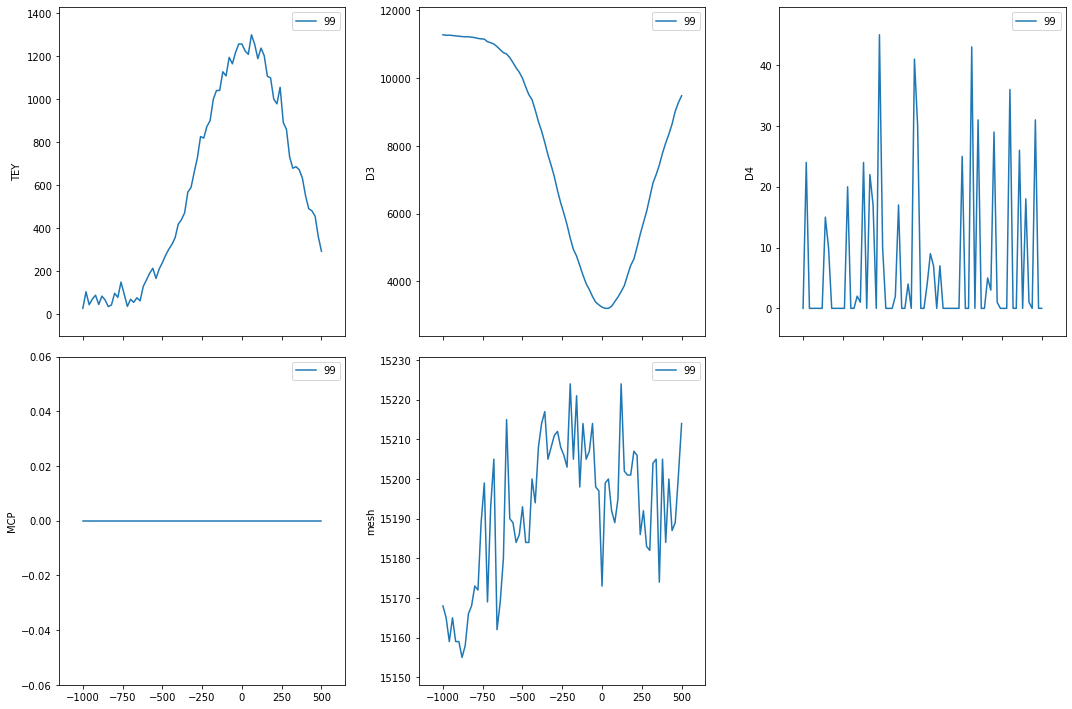

In [13]:
RE(bp.rel_scan([scaler],z_motor,750,-750,76))

/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


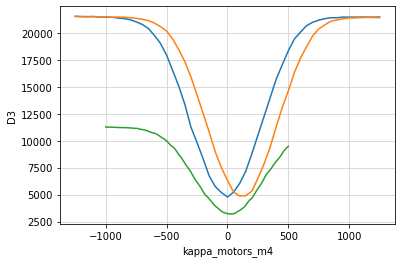

In [14]:
plot_run([92,93,99],z_motor,D3)


In [17]:
RE(uank(1,0.5+komega))

()

In [22]:
RE(mvy(4000))

()

In [15]:
th2thx_plan_test(1,10,0.05,4405,-5,komega)

npts: 181
x_start: 4405
x_stop: 3500
x_step: -5


In [21]:
th2thx_plan_test(8,28,0.05,3200,-5,komega)

npts: 401
x_start: 3200
x_stop: 1195
x_step: -5


In [18]:
srs4.sensitivity_unit.put(1);RE(bps.sleep(1)); u=srs4.sensitivity_unit.get()
srs4.sensitivity_value.put(7); RE(bps.sleep(1)); v=srs4.sensitivity_value.get()
print(v,u)

200 nA/V


In [ ]:
# changed gain by hand

sensitivity: 20 nA/V
gain: 2e-08


Transient Scan ID: 100     Time: 2021-12-04 15:57:23
Persistent Unique Scan ID: 'b2393d6c-94a0-419d-bf81-1f3e2606af44'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.497091680765152              |
|                    mono_energy | 520.0147783                    |
|              mono_mirror_pitch | 3.6361669921875                |
|             mono_grating_pitch | 4.928742041015625              |
|                    centroidM3R | 110.9298884589119              |
|                kappa_motors_m2 | 4605.092                       |
|                kappa_motors_m3 | 4000.203                       |
|                kappa_motors_m4 | -500.241                       |
|                kappa_motors_m9 | 1.0                            |
|                kappa_motors_m8 | 57.82214238179                 |
|                kappa_motors_m7 | 134.7560

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4973768889904022             |
|                    mono_energy | 520.0060292                    |
|              mono_mirror_pitch | 3.63620849609375               |
|             mono_grating_pitch | 4.928736547851563              |
|                    centroidM3R | 111.11809045226131             |
|                kappa_motors_m2 | 3499.951                       |
|                kappa_motors_m3 | 4000.327                       |
|                kappa_motors_m4 | -500.245                       |
|                kappa_motors_m9 | 20.0                           |
|                kappa_motors_m8 | 67.32214238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.04476708                    |
|                select_detector | d4                             |
+-----------------

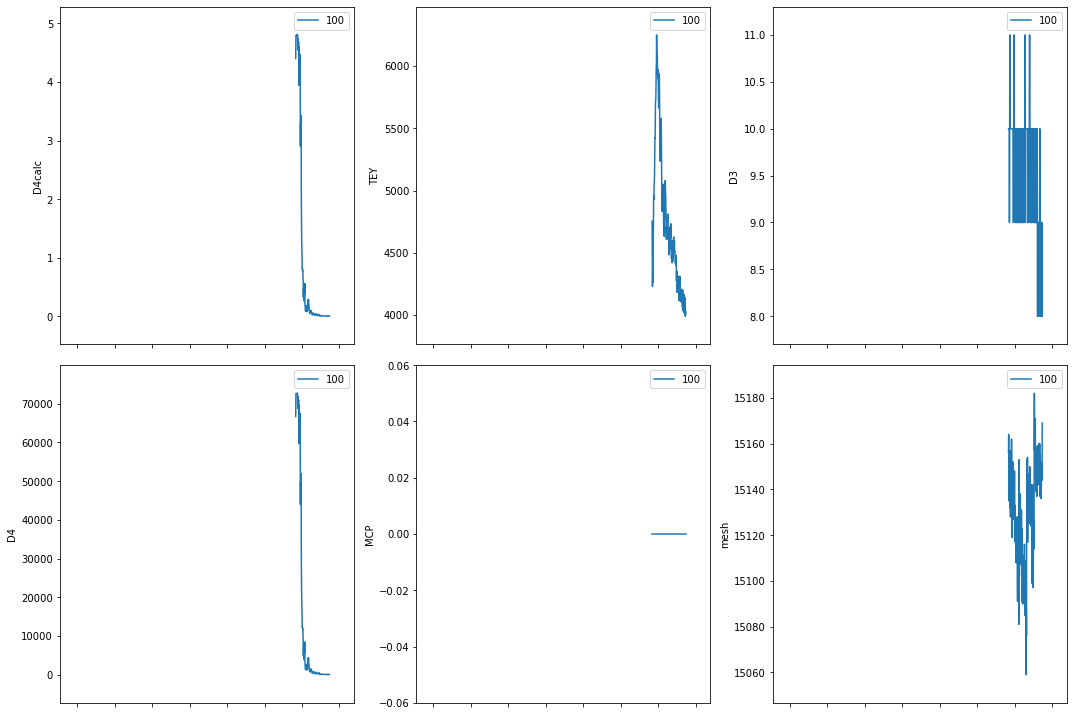

()

In [23]:
g=d4_gain()
RE(th2thx_plan(1,10,0.05,4405,-5,komega))
RE(plot_latest_plan(tth_motor,D4,log=True))

/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


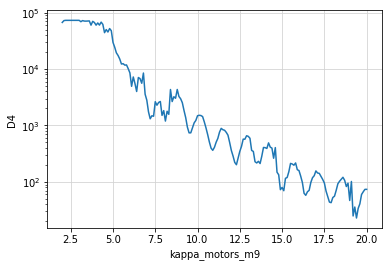

In [25]:
plot_latest(tth_motor,D4,log=True)

In [27]:
srs4.sensitivity_unit.put(0); RE(bps.sleep(1));u=srs4.sensitivity_unit.get()
srs4.sensitivity_value.put(6); RE(bps.sleep(1)); v=srs4.sensitivity_value.get()
print(v,u)

100 pA/V


In [28]:
RE(uank(15,7.5+komega))

()

sensitivity: 100 pA/V
gain: 1e-10


Transient Scan ID: 101     Time: 2021-12-04 16:13:37
Persistent Unique Scan ID: 'ea269af6-bbe2-4a03-ab25-07f521fdddc5'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4971630573272705             |
|                    mono_energy | 520.0022261                    |
|              mono_mirror_pitch | 3.6362347412109375             |
|             mono_grating_pitch | 4.92873837890625               |
|                    centroidM3R | 110.97639780018332             |
|                kappa_motors_m2 | 3499.831                       |
|                kappa_motors_m3 | 4000.244                       |
|                kappa_motors_m4 | -500.267                       |
|                kappa_motors_m9 | 15.0                           |
|                kappa_motors_m8 | 64.82214238179                 |
|                kappa_motors_m7 | 134.756

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4972343444824219             |
|                    mono_energy | 520.0106947                    |
|              mono_mirror_pitch | 3.636256103515625              |
|             mono_grating_pitch | 4.928722509765625              |
|                    centroidM3R | 110.99295044578064             |
|                kappa_motors_m2 | 1194.942                       |
|                kappa_motors_m3 | 4000.233                       |
|                kappa_motors_m4 | -500.26300000000003            |
|                kappa_motors_m9 | 56.0                           |
|                kappa_motors_m8 | 85.33514238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.04477247999999              |
|                select_detector | d4                             |
+-----------------

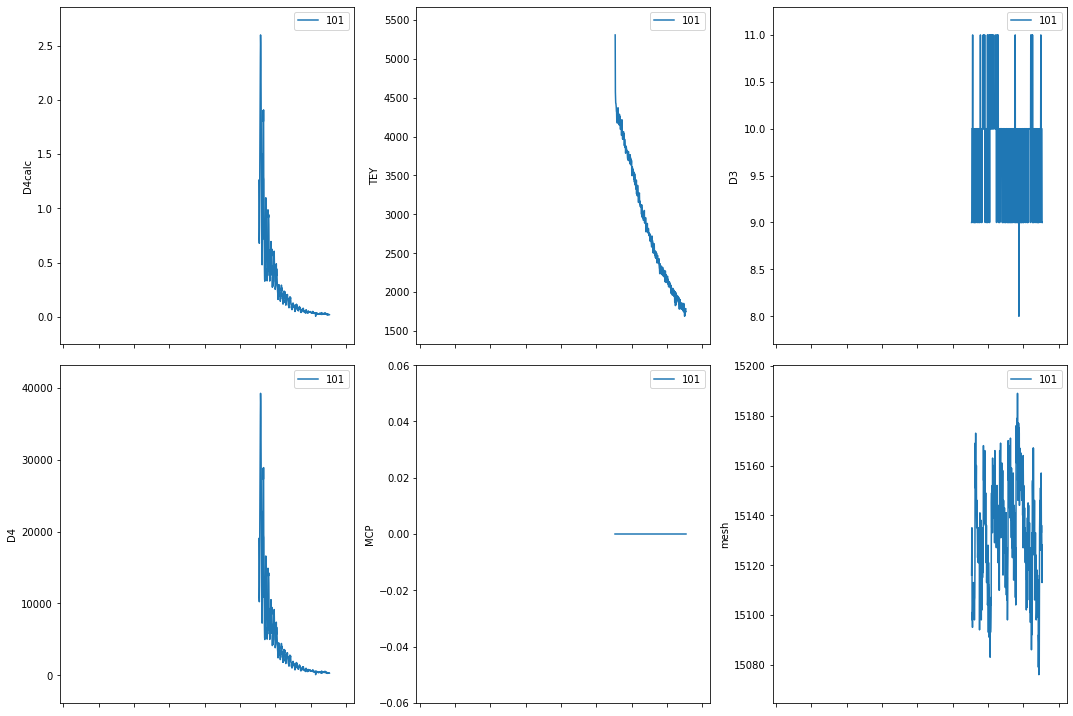

()

In [29]:
g=d4_gain()
RE(th2thx_plan(8,28,0.05,3200,-5,komega))
RE(plot_latest_plan(tth_motor,D4,log=True))

/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


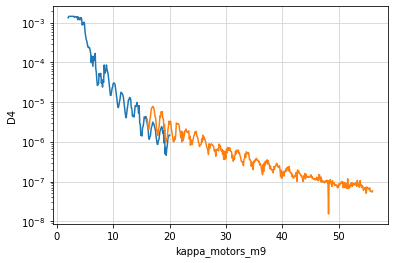

In [30]:
plot_run([[100,0,20e-9],[101,0,200e-12]],tth_motor,D4,log=True)

In [31]:
th2thx_plan_test(1,10,0.05,800,-5,komega)

npts: 181
x_start: 800
x_stop: -105
x_step: -5


In [32]:
th2thx_plan_test(8,28,0.05,-400,-5,komega)

npts: 401
x_start: -400
x_stop: -2405
x_step: -5


In [34]:
srs4.sensitivity_unit.put(1);RE(bps.sleep(1)); u=srs4.sensitivity_unit.get()
srs4.sensitivity_value.put(6); RE(bps.sleep(1)); v=srs4.sensitivity_value.get()
print(v,u)

100 nA/V


sensitivity: 100 nA/V
gain: 1.0000000000000001e-07


Transient Scan ID: 102     Time: 2021-12-04 16:27:39
Persistent Unique Scan ID: '12a06cc3-f575-42ae-95fd-b163901b2241'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4971630573272705             |
|                    mono_energy | 519.9972487                    |
|              mono_mirror_pitch | 3.636240234375                 |
|             mono_grating_pitch | 4.928726782226563              |
|                    centroidM3R | 110.6732192414431              |
|                kappa_motors_m2 | 1194.858                       |
|                kappa_motors_m3 | 4000.242                       |
|                kappa_motors_m4 | -500.273                       |
|                kappa_motors_m9 | 2.0                            |
|                kappa_motors_m8 | 58.32214238179                 |
|                kappa_mo

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4973768889904022             |
|                    mono_energy | 519.9910496                    |
|              mono_mirror_pitch | 3.636221923828125              |
|             mono_grating_pitch | 4.928744482421875              |
|                    centroidM3R | 110.68960529034925             |
|                kappa_motors_m2 | -105.06                        |
|                kappa_motors_m3 | 4000.234                       |
|                kappa_motors_m4 | -500.266                       |
|                kappa_motors_m9 | 20.0                           |
|                kappa_motors_m8 | 67.32214238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.045184680000006             |
|                select_detector | d4                             |
+-----------------

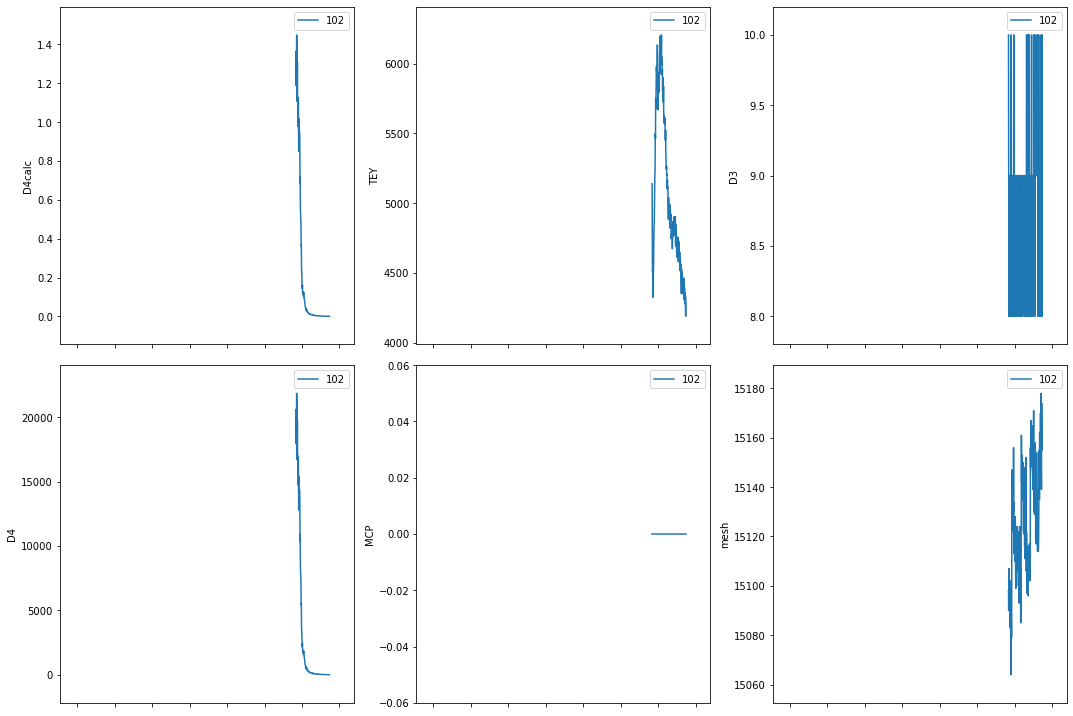

()

In [35]:
g=d4_gain()
RE(th2thx_plan(1,10,0.05,800,-5,komega))
RE(plot_latest_plan(tth_motor,D4,log=True))

/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


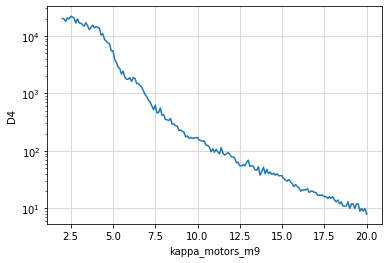

In [36]:
plot_latest(tth_motor,D4,log=True)

In [37]:
srs4.sensitivity_unit.put(0); RE(bps.sleep(1));u=srs4.sensitivity_unit.get()
srs4.sensitivity_value.put(6); RE(bps.sleep(1)); v=srs4.sensitivity_value.get()
print(v,u)

100 pA/V


In [38]:
RE(uank(15,7.5+komega))

()

sensitivity: 100 pA/V
gain: 1e-10


Transient Scan ID: 103     Time: 2021-12-04 16:31:30
Persistent Unique Scan ID: '448a7fb0-625e-4db1-801e-01eabb662f5a'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4972343444824219             |
|                    mono_energy | 520.0101445                    |
|              mono_mirror_pitch | 3.636209716796875              |
|             mono_grating_pitch | 4.92876767578125               |
|                    centroidM3R | 110.62364879770571             |
|                kappa_motors_m2 | -105.107                       |
|                kappa_motors_m3 | 4000.011                       |
|                kappa_motors_m4 | -500.293                       |
|                kappa_motors_m9 | 15.0                           |
|                kappa_motors_m8 | 64.82114238179003              |
|                kappa_motors_m7 | 134.756

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4974483549594879             |
|                    mono_energy | 520.0024852                    |
|              mono_mirror_pitch | 3.6362109375                   |
|             mono_grating_pitch | 4.9287408203125                |
|                    centroidM3R | 110.74753823591033             |
|                kappa_motors_m2 | -2405.059                      |
|                kappa_motors_m3 | 4000.223                       |
|                kappa_motors_m4 | -500.25800000000004            |
|                kappa_motors_m9 | 56.0                           |
|                kappa_motors_m8 | 85.32214238179003              |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.04521348                    |
|                select_detector | d4                             |
+-----------------

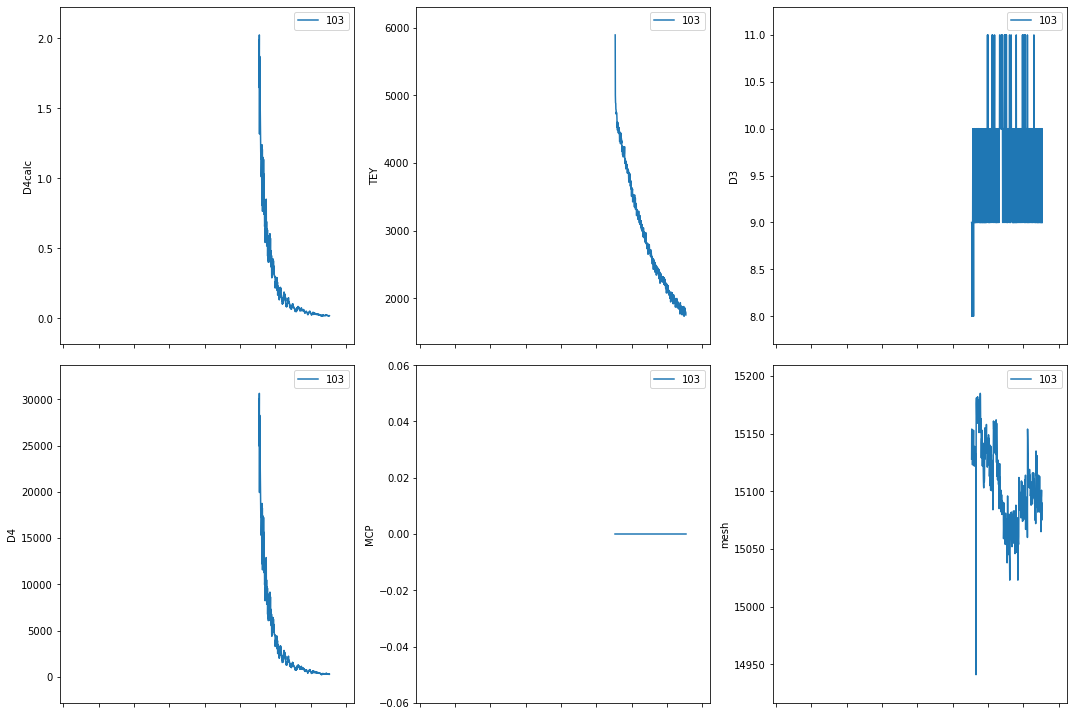

()

In [39]:
g=d4_gain()
RE(th2thx_plan(8,28,0.05,-400,-5,komega))
RE(plot_latest_plan(tth_motor,D4,log=True))

/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


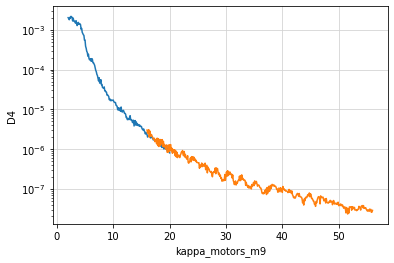

In [40]:
plot_run([[102,0,1e-7],[103,0,100e-12]],tth_motor,D4,log=True)

In [5]:
RE(uank(0,komega))

()

In [6]:
mprint()

x,y,z,tth,th,chi,phi = [-0.0,0.0,-250.0,0.0,57.32,134.75600000000003,57.05]


[-0.0, 0.0, -250.0, 0.0, 57.32, 134.75600000000003, 57.05]



Transient Scan ID: 105     Time: 2021-12-04 17:01:49
Persistent Unique Scan ID: '88dab03d-fd0a-43f0-ade5-69fcd7181ada'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4973768889904022             |
|                    mono_energy | 519.9914569                    |
|              mono_mirror_pitch | 3.6362371826171875             |
|             mono_grating_pitch | 4.928732275390625              |
|                    centroidM3R | 110.3735533647664              |
|                kappa_motors_m2 | -0.007                         |
|                kappa_motors_m3 | 0.254                          |
|                kappa_motors_m4 | 750.067                        |
|                kappa_motors_m9 | 0.0                            |
|                kappa_motors_m8 | 57.32214238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|       

('88dab03d-fd0a-43f0-ade5-69fcd7181ada',)

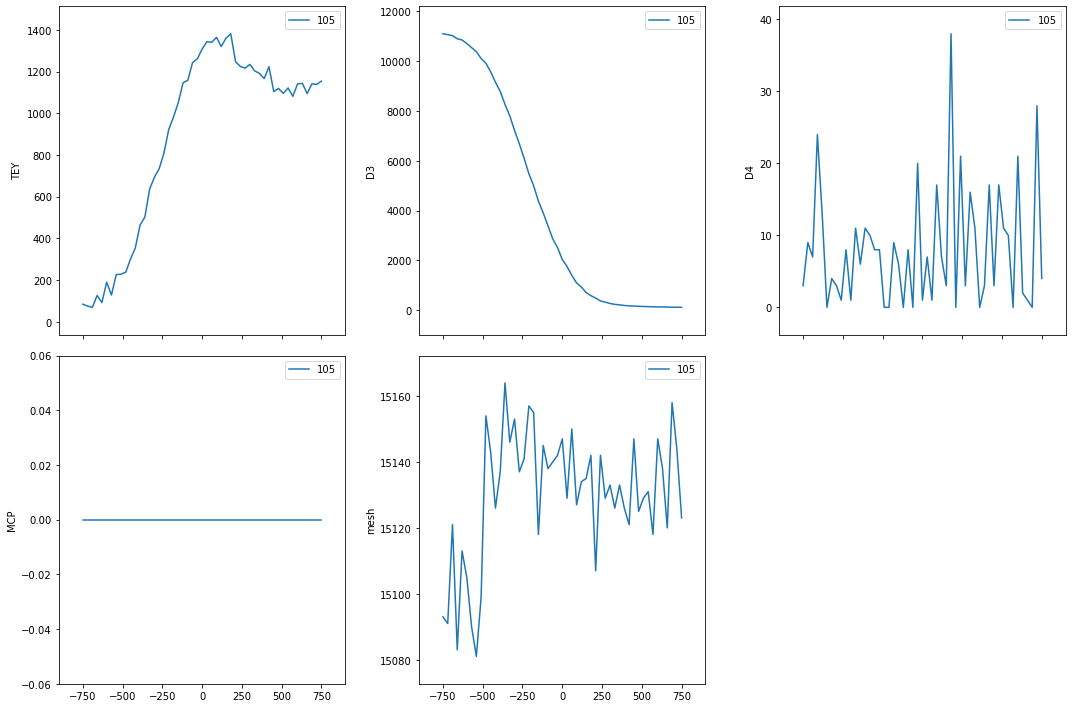

In [8]:
RE(bp.scan([scaler],z_motor,-750,750,51))



Transient Scan ID: 106     Time: 2021-12-04 17:03:33
Persistent Unique Scan ID: '151d9989-e902-47b9-aeb7-56622aec30c7'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4973768889904022             |
|                    mono_energy | 519.9921604                    |
|              mono_mirror_pitch | 3.6361871337890626             |
|             mono_grating_pitch | 4.92872373046875               |
|                    centroidM3R | 110.38395034360452             |
|                kappa_motors_m2 | 0.0                            |
|                kappa_motors_m3 | 0.247                          |
|                kappa_motors_m4 | -250.251                       |
|                kappa_motors_m9 | 0.0                            |
|                kappa_motors_m8 | 57.32214238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|       

('151d9989-e902-47b9-aeb7-56622aec30c7',)

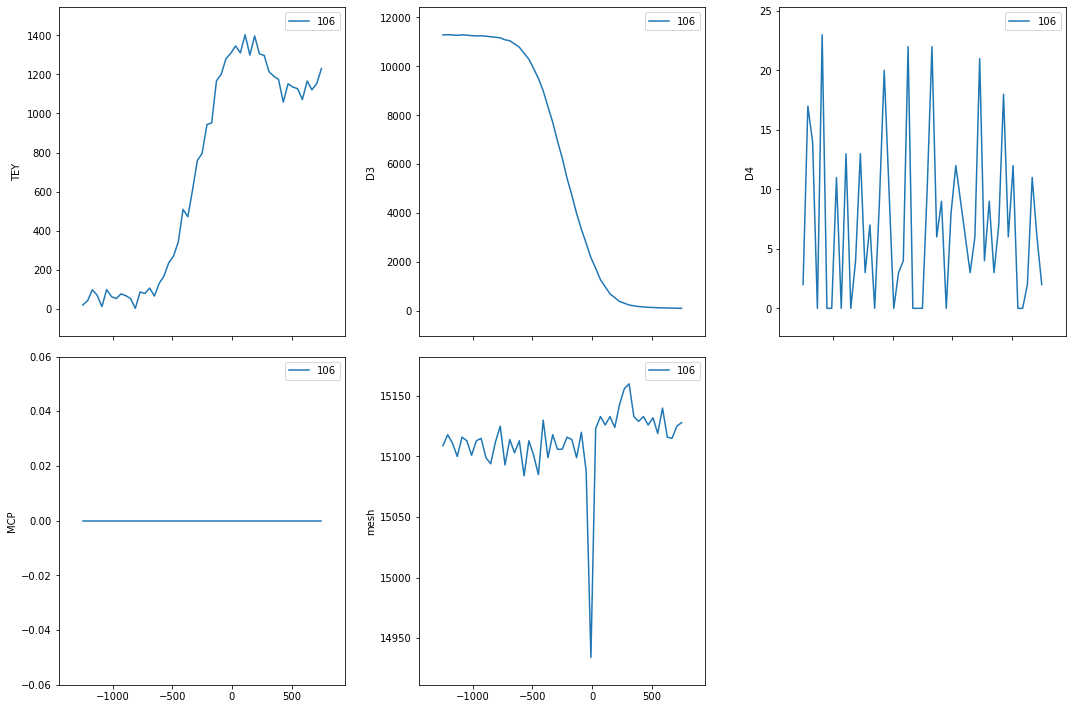

In [9]:
RE(bp.rel_scan([scaler],z_motor,-1000,1000,51))

In [11]:
find_z()

Array is :  [11285. 11289. 11281. 11267. 11284. 11271. 11255. 11241. 11248. 11230.
 11208. 11185. 11164. 11084. 11044. 10914. 10781. 10534. 10293.  9909.
  9508.  9001.  8350.  7712.  6948.  6248.  5424.  4744.  3987.  3347.
  2776.  2184.  1752.  1283.   995.   706.   549.   395.   323.   251.
   217.   187.   170.   157.   148.   139.   134.   128.   123.   118.
   114.]
Value to which nearest element is to be found:  5587.5
Nearest element to the given values is :  5424.0
Index of nearest value is :  26
Corresponding motor position of nearest value is :  -2.10243e+02


In [13]:
RE(mvz(-210))

()

In [18]:
slits.V4size.move(0)

MoveStatus(done=True, pos=motors_V4size, elapsed=1.1, success=True, settle_time=0.0)

In [14]:
th2thx_plan_test(1,10,0.05,-500,-5,komega)

npts: 181
x_start: -500
x_stop: -1405
x_step: -5


In [15]:
th2thx_plan_test(8,28,0.05,-1700,-5,komega)

npts: 401
x_start: -1700
x_stop: -3705
x_step: -5


In [19]:
srs4.sensitivity_unit.put(1);RE(bps.sleep(1)); u=srs4.sensitivity_unit.get()
srs4.sensitivity_value.put(7); RE(bps.sleep(1)); v=srs4.sensitivity_value.get()
print(v,u)

200 nA/V


sensitivity: 200 nA/V
gain: 2.0000000000000002e-07


Transient Scan ID: 107     Time: 2021-12-04 17:09:09
Persistent Unique Scan ID: '07fb71b5-f76c-4811-a580-4795f84834f9'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.49751967191696167            |
|                    mono_energy | 520.0037864                    |
|              mono_mirror_pitch | 3.6362017822265624             |
|             mono_grating_pitch | 4.928757299804688              |
|                    centroidM3R | 110.41138211382113             |
|                kappa_motors_m2 | 0.002                          |
|                kappa_motors_m3 | -2500.001                      |
|                kappa_motors_m4 | -209.877                       |
|                kappa_motors_m9 | 2.0                            |
|                kappa_motors_m8 | 58.32214238179                 |
|                kappa_mo

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4974483549594879             |
|                    mono_energy | 520.0120382                    |
|              mono_mirror_pitch | 3.6362567138671875             |
|             mono_grating_pitch | 4.92877255859375               |
|                    centroidM3R | 110.38259611409673             |
|                kappa_motors_m2 | -105.054                       |
|                kappa_motors_m3 | -2499.987                      |
|                kappa_motors_m4 | -209.85500000000002            |
|                kappa_motors_m9 | 20.0                           |
|                kappa_motors_m8 | 67.32214238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.04498848                    |
|                select_detector | d4                             |
+-----------------

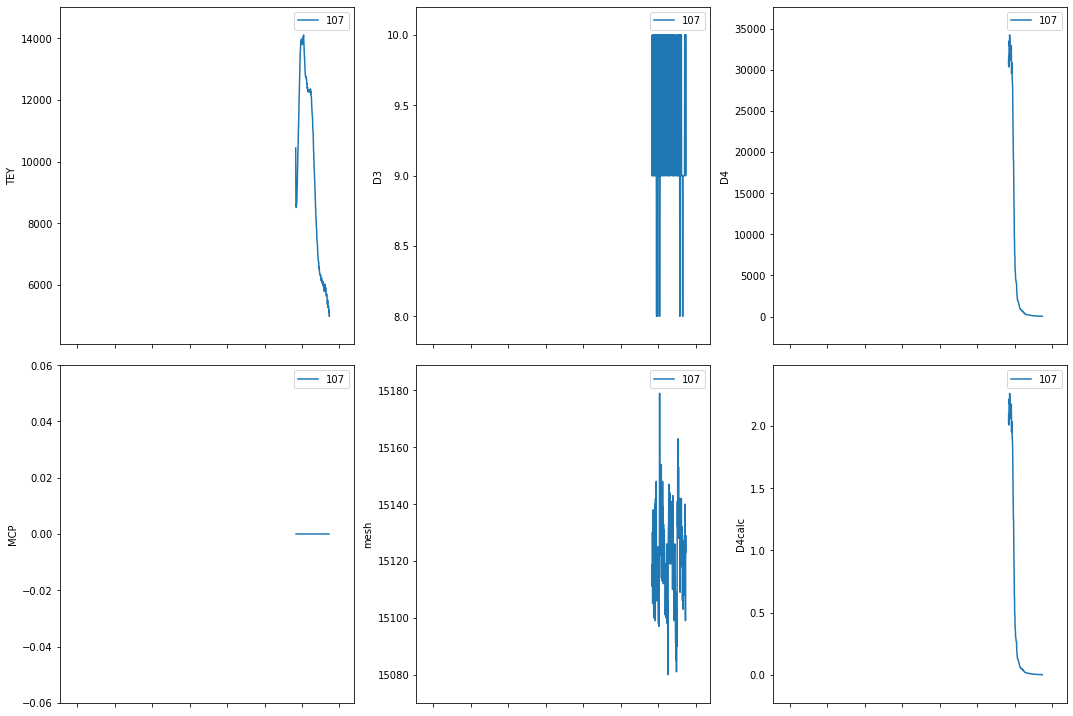

()

In [20]:
g=d4_gain()
y_motor.move(-2500)
slits.V4size.move(200)
RE(th2thx_plan(1,10,0.05,800,-5,komega))
RE(plot_latest_plan(tth_motor,D4,log=True))

/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


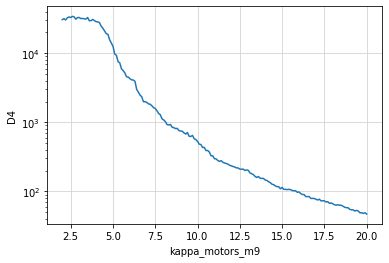

In [21]:
plot_latest(tth_motor,D4,log=True)

In [22]:
srs4.sensitivity_unit.put(0); RE(bps.sleep(1));u=srs4.sensitivity_unit.get()
srs4.sensitivity_value.put(7); RE(bps.sleep(1)); v=srs4.sensitivity_value.get()
print(v,u)

200 pA/V


In [23]:
RE(uank(15,7.5+komega))

()

sensitivity: 200 pA/V
gain: 2e-10


Transient Scan ID: 108     Time: 2021-12-04 17:13:11
Persistent Unique Scan ID: '74dfb906-b30a-4b7d-8450-cbfab88a7626'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4971630573272705             |
|                    mono_energy | 520.0043789                    |
|              mono_mirror_pitch | 3.6362066650390625             |
|             mono_grating_pitch | 4.928727392578125              |
|                    centroidM3R | 110.48756001745963             |
|                kappa_motors_m2 | -105.108                       |
|                kappa_motors_m3 | -2499.902                      |
|                kappa_motors_m4 | -209.83100000000002            |
|                kappa_motors_m9 | 15.0                           |
|                kappa_motors_m8 | 64.82214238179                 |
|                kappa_motors_m7 | 134.755

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.4973768889904022             |
|                    mono_energy | 520.0011893                    |
|              mono_mirror_pitch | 3.6361920166015627             |
|             mono_grating_pitch | 4.9287408203125                |
|                    centroidM3R | 110.25286581254214             |
|                kappa_motors_m2 | -2405.054                      |
|                kappa_motors_m3 | -2500.0190000000002            |
|                kappa_motors_m4 | -209.826                       |
|                kappa_motors_m9 | 56.0                           |
|                kappa_motors_m8 | 85.32314238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.045005759999995             |
|                select_detector | d4                             |
+-----------------

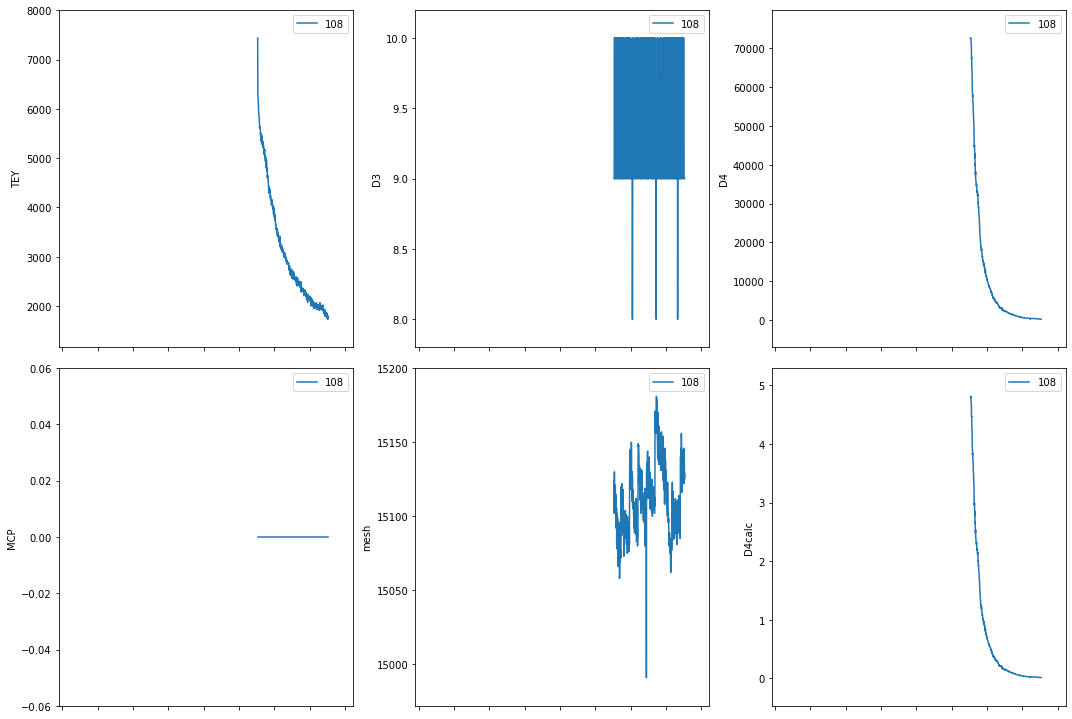

()

In [24]:
g=d4_gain()
RE(th2thx_plan(8,28,0.05,-400,-5,komega))
RE(plot_latest_plan(tth_motor,D4,log=True))

In [26]:
slits.V4size.move(0)

MoveStatus(done=True, pos=motors_V4size, elapsed=1.1, success=True, settle_time=0.0)

/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


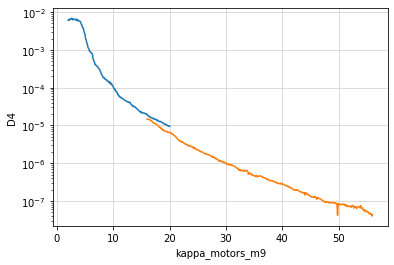

In [28]:
plot_run([[107,0,2e-7],[108,0,200e-12]],tth_motor,D4,log=True)

# New sample - E = 536 eV

In [1]: energy(536,c=0.5,m3r=False)
ID Ready

ID SET : 545.9 eV
ID RBV : 514.4 eV
Down Table
Mono set to 536 eV


Mono set to 536 eV




Transient Scan ID: 109     Time: 2021-12-04 17:48:57
Persistent Unique Scan ID: '0d022b3c-e819-40b3-aa48-65348fec843a'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.5147045254707336             |
|                    mono_energy | 536.0064099                    |
|              mono_mirror_pitch | 3.5813970947265625             |
|             mono_grating_pitch | 4.854491552734375              |
|                    centroidM3R | 110.5                          |
|                kappa_motors_m2 | -0.34400000000000003           |
|                kappa_motors_m3 | 0.12                           |
|                kappa_motors_m4 | -249.924                       |
|                kappa_motors_m9 | 0.0                            |
|                kappa_motors_m8 | 57.32214238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|       

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.5144049525260925             |
|                    mono_energy | 535.9914946                    |
|              mono_mirror_pitch | 3.5813934326171877             |
|             mono_grating_pitch | 4.8545123046875                |
|                    centroidM3R | 110.81818181818181             |
|                kappa_motors_m2 | -0.342                         |
|                kappa_motors_m3 | 0.106                          |
|                kappa_motors_m4 | -999.936                       |
|                kappa_motors_m9 | 0.0                            |
|                kappa_motors_m8 | 57.32214238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.04864644                    |
|                select_detector | d3                             |
+-----------------

('0d022b3c-e819-40b3-aa48-65348fec843a',)

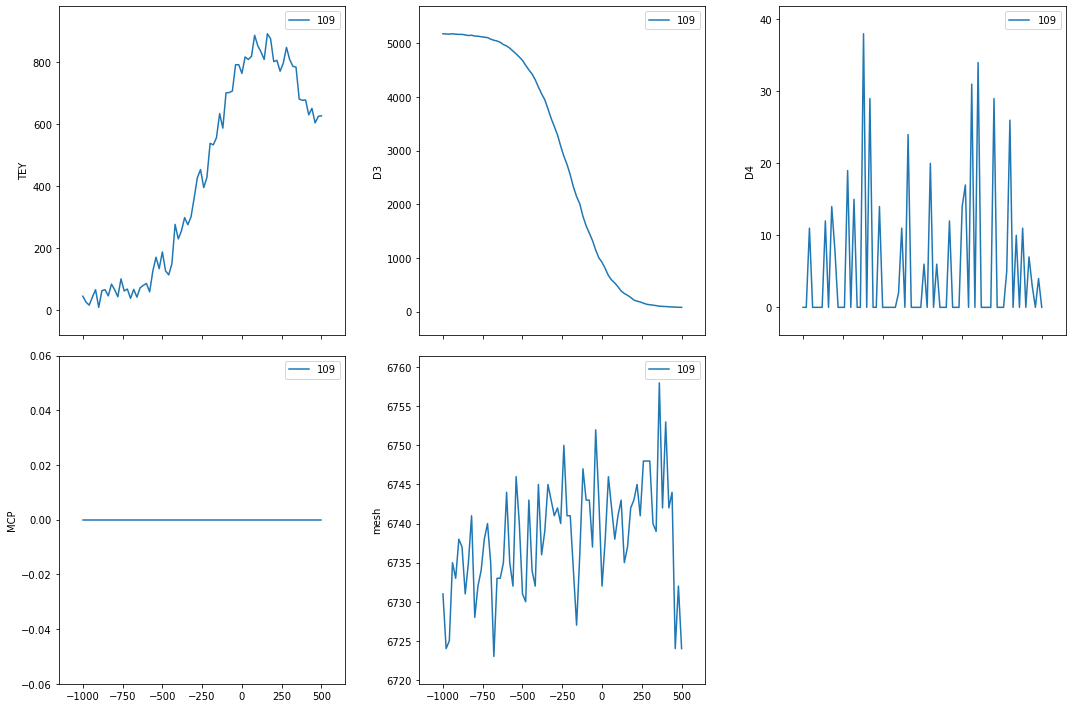

In [29]:
RE(bp.rel_scan([scaler],z_motor,750,-750,76))

/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


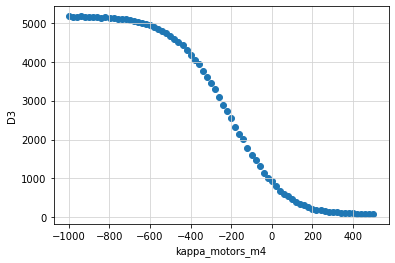

In [30]:
plot_scatter(-1,z_motor,D3)

In [31]:
find_z()

Array is :  [  80.   81.   84.   87.   90.   95.   98.  102.  112.  121.  128.  138.
  158.  180.  195.  216.  264.  305.  338.  384.  464.  533.  590.  672.
  802.  918. 1001. 1148. 1324. 1462. 1598. 1774. 2007. 2143. 2322. 2548.
 2739. 2894. 3083. 3291. 3447. 3599. 3776. 3945. 4056. 4183. 4318. 4425.
 4501. 4588. 4678. 4741. 4799. 4853. 4906. 4947. 4973. 5015. 5039. 5053.
 5074. 5103. 5110. 5118. 5129. 5131. 5147. 5141. 5152. 5162. 5163. 5166.
 5174. 5167. 5169. 5174.]
Value to which nearest element is to be found:  2547.0
Nearest element to the given values is :  2548.0
Index of nearest value is :  35
Corresponding motor position of nearest value is :  -199.918


In [32]:
RE(mvz(-200))

()

In [33]:
komega

57.322396707958816

In [ ]:
# move to d4

In [35]:
RE(uank(20,komega+10))

()



Transient Scan ID: 110     Time: 2021-12-04 17:55:07
Persistent Unique Scan ID: '6353e9f2-ffba-4b0b-bfa3-97f10e94db75'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.5144798159599304             |
|                    mono_energy | 535.9979687                    |
|              mono_mirror_pitch | 3.5814117431640624             |
|             mono_grating_pitch | 4.85448544921875               |
|                    centroidM3R | 110.6923076923077              |
|                kappa_motors_m2 | -0.327                         |
|                kappa_motors_m3 | 0.112                          |
|                kappa_motors_m4 | -199.881                       |
|                kappa_motors_m9 | 20.0                           |
|                kappa_motors_m8 | 67.32214238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|       

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.5144049525260925             |
|                    mono_energy | 535.9886904                    |
|              mono_mirror_pitch | 3.581392822265625              |
|             mono_grating_pitch | 4.854469580078125              |
|                    centroidM3R | 110.28571428571429             |
|                kappa_motors_m2 | -0.326                         |
|                kappa_motors_m3 | 0.109                          |
|                kappa_motors_m4 | -199.871                       |
|                kappa_motors_m9 | 20.0                           |
|                kappa_motors_m8 | 68.32214238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.04864752                    |
|                select_detector | d4                             |
+-----------------

('6353e9f2-ffba-4b0b-bfa3-97f10e94db75',)

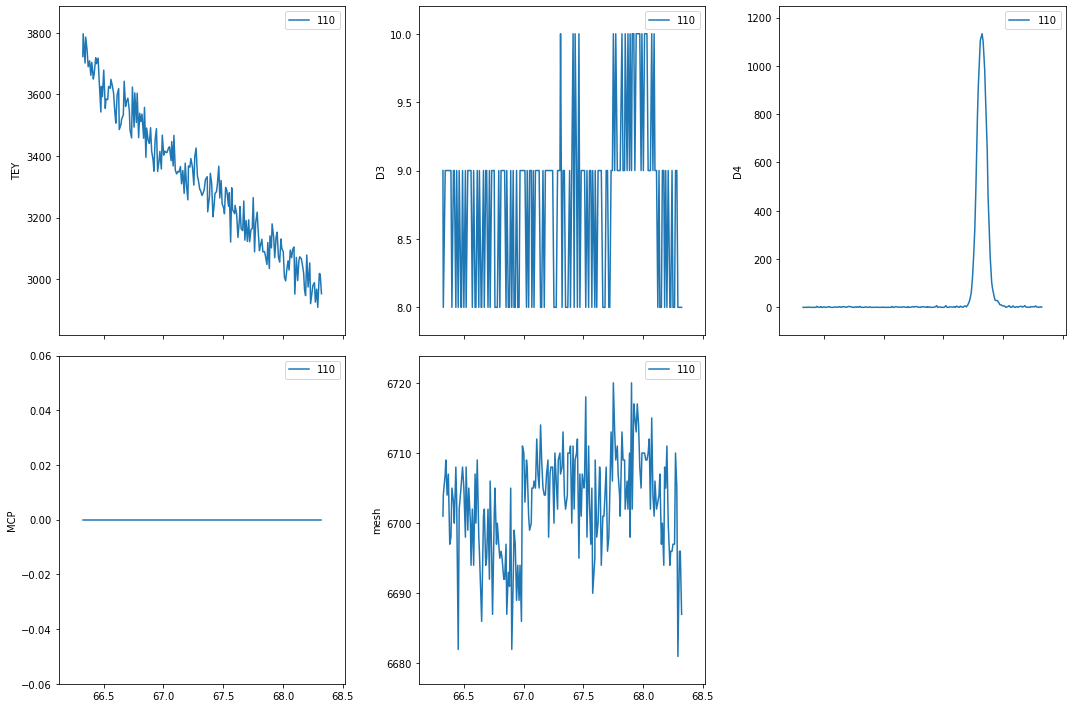

In [36]:
RE(bp.rel_scan([scaler],kth_motor,-1,1,201))

In [40]:
playsound()

Playing WAVE '/home/beams/29IDUSER/Documents/User_Macros/Macros_29id/Sound_Files/VictoryFF.wav' : Signed 16 bit Little Endian, Rate 48000 Hz, Stereo


In [41]:
peaks

{
'com':
    {'D3': 67.32952000813867,
     'D4': 67.8130933922003,
     'MCP': nan,
     'TEY': 67.28571193513915,
     'mesh': 67.32226454199427}
,
'cen':
    {'D3': 67.79009550679001,
     'D4': 67.82183420427256,
     'MCP': None,
     'TEY': 67.16030265882124,
     'mesh': 67.1251507812167}
,
'max':
    {'D3': (67.30914238179002,
            10.0),
     'D4': (67.82314238179,
            1133.0),
     'MCP': (66.32514238179002,
             0.0),
     'TEY': (66.32814238179,
             3797.0),
     'mesh': (67.75114238179,
              6720.0)}
,
'min':
    {'D3': (66.32814238179,
            8.0),
     'D4': (66.32514238179002,
            0.0),
     'MCP': (66.32514238179002,
             0.0),
     'TEY': (68.29114238179002,
             2909.0),
     'mesh': (68.29114238179002,
              6681.0)}
,
'fwhm':
    {'D3': 0.7949999999999875,
     'D4': 0.09481842757377024,
     'MCP': None,
     'TEY': 0.5444762675296744,
     'mesh': 1.9058875000000057}
,
}

/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


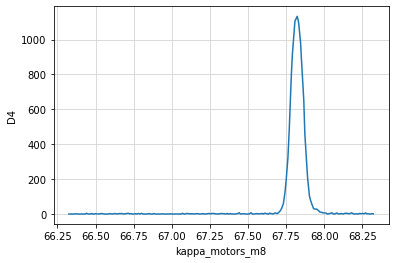

In [42]:
plot_latest(kth_motor,D4)

In [45]:
peaks['cen']['D4']

67.82183420427256

In [46]:
kth_motor.move(peaks['cen']['D4'])

MoveStatus(done=True, pos=kappa_motors_m8, elapsed=1.4, success=True, settle_time=0.0)

In [47]:
peaks['cen']['D4']-57.045

10.77683420427256

In [48]:
peaks['cen']['D4']-57.045-10

0.7768342042725607

In [49]:
peaks['cen']['D4']-10

57.82183420427256

In [50]:
komega=57.82183420427256

In [55]:
RE(uank(0,komega))

()



Transient Scan ID: 111     Time: 2021-12-04 18:06:21
Persistent Unique Scan ID: 'fcc24093-9f58-41e8-9eec-f0ad79f037c0'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.5147794485092163             |
|                    mono_energy | 536.0097876                    |
|              mono_mirror_pitch | 3.5813507080078124             |
|             mono_grating_pitch | 4.854467138671875              |
|                    centroidM3R | 110.66666666666667             |
|                kappa_motors_m2 | -0.303                         |
|                kappa_motors_m3 | 0.116                          |
|                kappa_motors_m4 | -199.854                       |
|                kappa_motors_m9 | 0.0                            |
|                kappa_motors_m8 | 57.82214238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|       

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.5144049525260925             |
|                    mono_energy | 535.981087                     |
|              mono_mirror_pitch | 3.581385498046875              |
|             mono_grating_pitch | 4.854498266601563              |
|                    centroidM3R | 111.13333333333334             |
|                kappa_motors_m2 | -0.3                           |
|                kappa_motors_m3 | 0.10400000000000001            |
|                kappa_motors_m4 | -949.852                       |
|                kappa_motors_m9 | 0.0                            |
|                kappa_motors_m8 | 57.82214238179                 |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.04854204                    |
|                select_detector | d3                             |
+-----------------

('fcc24093-9f58-41e8-9eec-f0ad79f037c0',)

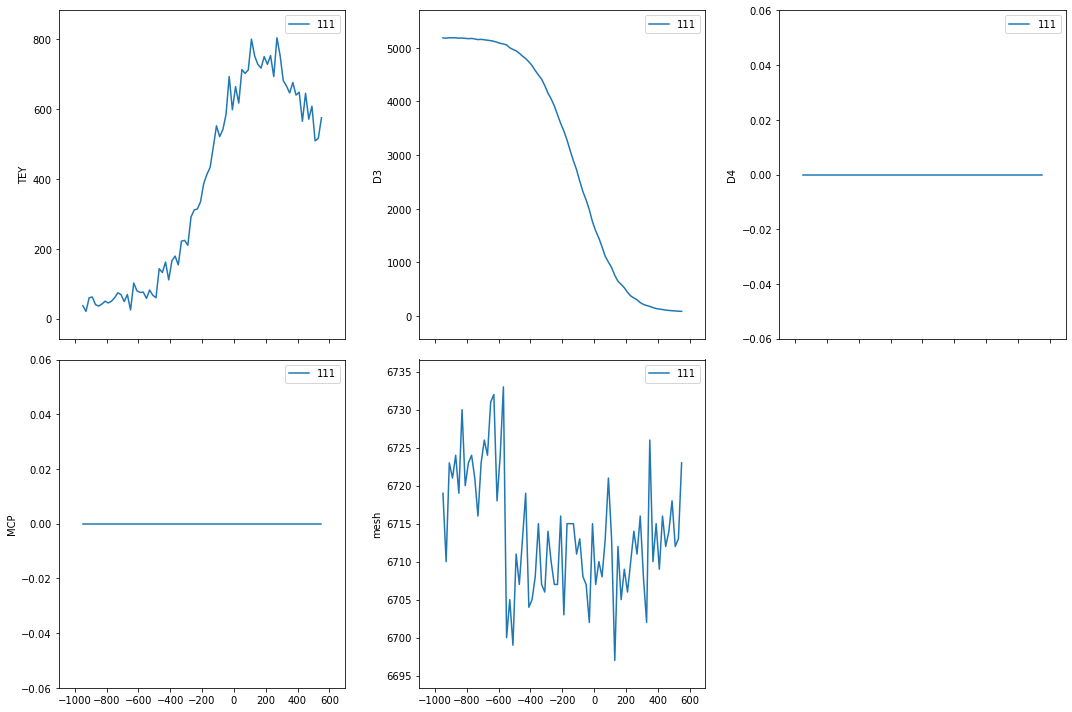

In [56]:
RE(bp.rel_scan([scaler],z_motor,750,-750,76))

/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


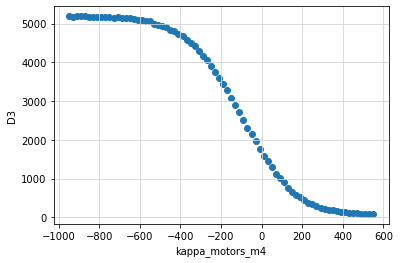

In [57]:
plot_scatter(-1,z_motor,D3)

In [58]:
find_z()

Array is :  [  86.   89.   93.   98.  103.  109.  120.  128.  138.  155.  178.  195.
  215.  249.  302.  335.  374.  442.  525.  589.  647.  757.  903. 1004.
 1112. 1288. 1453. 1587. 1755. 1980. 2163. 2316. 2512. 2726. 2893. 3082.
 3279. 3448. 3591. 3752. 3918. 4049. 4156. 4296. 4417. 4494. 4577. 4670.
 4740. 4800. 4845. 4900. 4944. 4970. 5001. 5056. 5072. 5084. 5104. 5122.
 5134. 5142. 5150. 5158. 5154. 5166. 5175. 5171. 5177. 5182. 5180. 5187.
 5188. 5188. 5180. 5186.]
Value to which nearest element is to be found:  2551.0
Nearest element to the given values is :  2512.0
Index of nearest value is :  32
Corresponding motor position of nearest value is :  -89.852


In [59]:
playsound()

Playing WAVE '/home/beams/29IDUSER/Documents/User_Macros/Macros_29id/Sound_Files/VictoryFF.wav' : Signed 16 bit Little Endian, Rate 48000 Hz, Stereo


In [62]:
komega-57.045

0.7768342042725607

In [63]:
RE(mvz(-90))

()

In [67]:
RE(uank(30,komega+15))

()



Transient Scan ID: 113     Time: 2021-12-04 18:11:13
Persistent Unique Scan ID: '5e37276c-c53a-4ca5-b63d-3ce4dcca296a'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.5144049525260925             |
|                    mono_energy | 536.0101192                    |
|              mono_mirror_pitch | 3.581337890625                 |
|             mono_grating_pitch | 4.85448544921875               |
|                    centroidM3R | 111.16666666666667             |
|                kappa_motors_m2 | -0.291                         |
|                kappa_motors_m3 | 0.112                          |
|                kappa_motors_m4 | -89.878                        |
|                kappa_motors_m9 | 30.0                           |
|                kappa_motors_m8 | 72.82214238179                 |
|                kappa_motors_m7 | 134.755                        |
|       

('5e37276c-c53a-4ca5-b63d-3ce4dcca296a',)

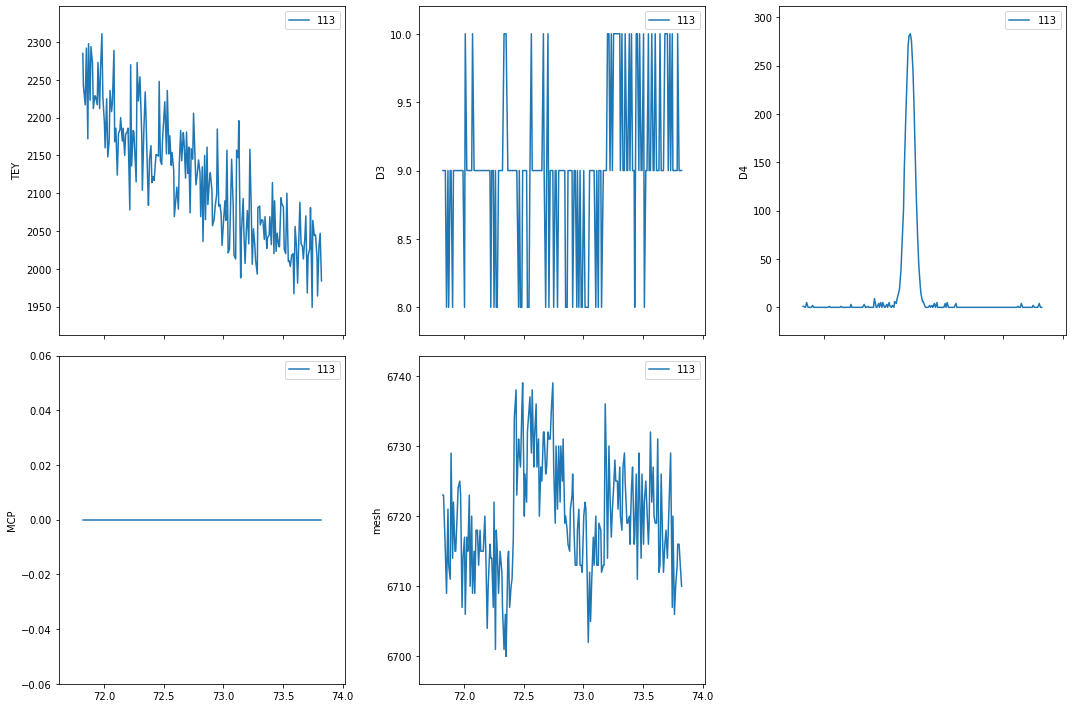

In [68]:
RE(bp.rel_scan([scaler],kth_motor,-1,1,201))

In [70]:
playsound()

Playing WAVE '/home/beams/29IDUSER/Documents/User_Macros/Macros_29id/Sound_Files/VictoryFF.wav' : Signed 16 bit Little Endian, Rate 48000 Hz, Stereo


In [71]:
peaks

{
'com':
    {'D3': 72.829013171409,
     'D4': 72.71602662836534,
     'MCP': nan,
     'TEY': 72.8050297098047,
     'mesh': 72.82317580999081}
,
'cen':
    {'D3': 73.21839238179001,
     'D4': 72.71784939933387,
     'MCP': None,
     'TEY': 72.69276094502568,
     'mesh': 72.92907776759968}
,
'max':
    {'D3': (72.00914238179001,
            10.0),
     'D4': (72.72114238179,
            283.0),
     'MCP': (71.82214238179,
             0.0),
     'TEY': (71.98214238179003,
             2311.0),
     'mesh': (72.49014238179001,
              6739.0)}
,
'min':
    {'D3': (71.85214238179,
            8.0),
     'D4': (71.84214238179001,
            0.0),
     'MCP': (71.82214238179,
             0.0),
     'TEY': (73.74414238179003,
             1949.0),
     'mesh': (72.35114238179003,
              6700.0)}
,
'fwhm':
    {'D3': 1.7950000000000017,
     'D4': 0.09518596491227527,
     'MCP': None,
     'TEY': 1.1162679569892333,
     'mesh': 1.9159017857142828}
,
}

/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


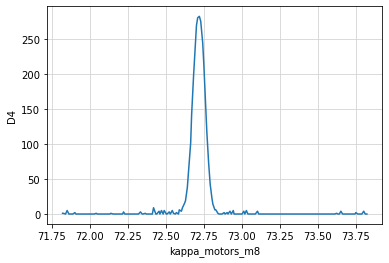

In [72]:
plot_latest(kth_motor,D4)

In [73]:
peaks['cen']['D4']

72.71784939933387

In [74]:
kth_motor.move(peaks['cen']['D4'])

MoveStatus(done=True, pos=kappa_motors_m8, elapsed=0.6, success=True, settle_time=0.0)

In [75]:
peaks['cen']['D4']-57.045

15.67284939933387

In [76]:
peaks['cen']['D4']-57.045-15

0.6728493993338702

In [77]:
peaks['cen']['D4']-15

57.71784939933387

In [78]:
komega=peaks['cen']['D4']-15

In [81]:
komega

57.71784939933387

## Specular centered on MCP

In [86]:
mprint()

x,y,z,tth,th,chi,phi = [-0.0,0.0,-90.0,30.3,72.1,133.71699999999998,56.38]


[-0.0, 0.0, -90.0, 30.3, 72.1, 133.71699999999998, 56.38]

## Reflectivity @ 536eV

In [88]:
RE(mvy(-1500))

()

In [90]:
th2thx_plan_test(1,10,0.05,-300,-5,komega)

npts: 181
x_start: -300
x_stop: -1205
x_step: -5


In [91]:
th2thx_plan_test(8,28,0.05,-1500,5,komega)

npts: 401
x_start: -1500
x_stop: 505
x_step: 5


In [93]:
srs4.sensitivity_unit.put(1);RE(bps.sleep(1)); u=srs4.sensitivity_unit.get()
srs4.sensitivity_value.put(2); RE(bps.sleep(1)); v=srs4.sensitivity_value.get()
print(v,u)

5 nA/V


In [97]:
RE(uank(1,0.5+komega))

()

In [98]:
slits.V4size.move(200)

MoveStatus(done=True, pos=motors_V4size, elapsed=1.1, success=True, settle_time=0.0)

sensitivity: 5 nA/V
gain: 5e-09


Transient Scan ID: 115     Time: 2021-12-04 18:33:35
Persistent Unique Scan ID: 'dda088a7-5cd7-4f04-999b-8e1fda10a4c1'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.5145546793937683             |
|                    mono_energy | 536.0012395                    |
|              mono_mirror_pitch | 3.5813305664062502             |
|             mono_grating_pitch | 4.854487890625                 |
|                    centroidM3R | 111.26086956521739             |
|                kappa_motors_m2 | 564.777                        |
|                kappa_motors_m3 | -1500.002                      |
|                kappa_motors_m4 | -89.84                         |
|                kappa_motors_m9 | 1.0                            |
|                kappa_motors_m8 | 58.21814238179002              |
|                kappa_motors_m7 | 134.755  

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.5144049525260925             |
|                    mono_energy | 536.0075508                    |
|              mono_mirror_pitch | 3.58138671875                  |
|             mono_grating_pitch | 4.854495825195313              |
|                    centroidM3R | 111.4                          |
|                kappa_motors_m2 | -1205.036                      |
|                kappa_motors_m3 | -1500.026                      |
|                kappa_motors_m4 | -89.825                        |
|                kappa_motors_m9 | 20.0                           |
|                kappa_motors_m8 | 67.71714238179001              |
|                kappa_motors_m7 | 134.755                        |
|                kappa_motors_m1 | 57.04495247999999              |
|                select_detector | d4                             |
+-----------------

('dda088a7-5cd7-4f04-999b-8e1fda10a4c1',)

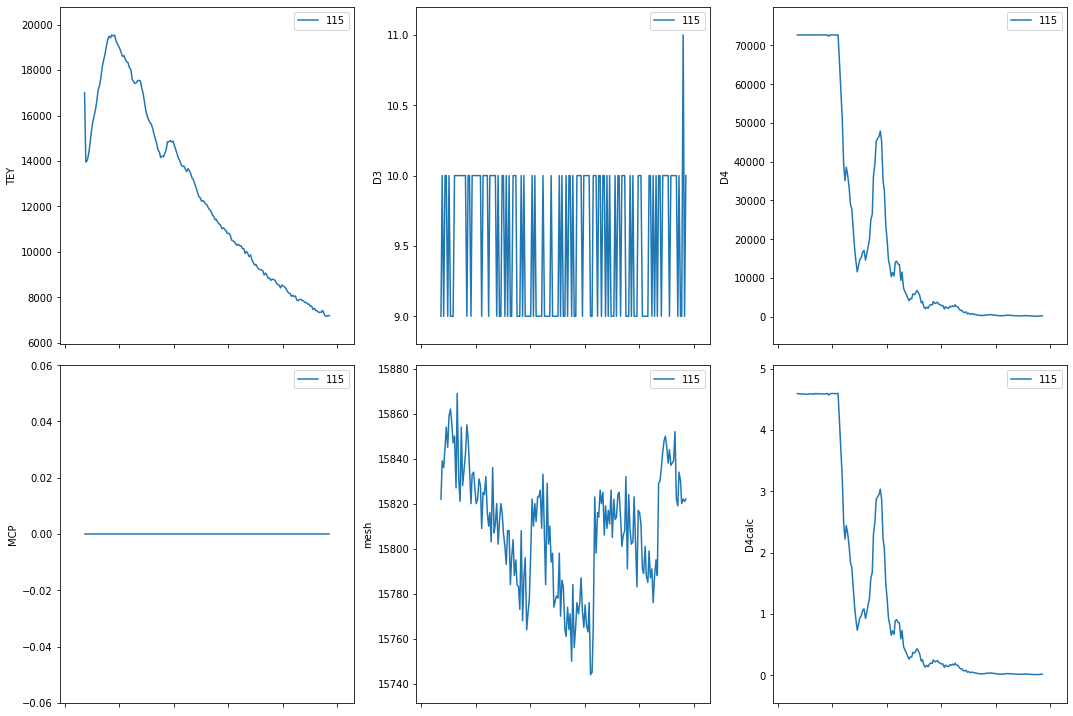

In [99]:
g=d4_gain();RE(th2thx_plan(1,10,0.05,-300,-5,komega)); slits.V4size.move(0)

In [100]:
playsound()

Playing WAVE '/home/beams/29IDUSER/Documents/User_Macros/Macros_29id/Sound_Files/VictoryFF.wav' : Signed 16 bit Little Endian, Rate 48000 Hz, Stereo


/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


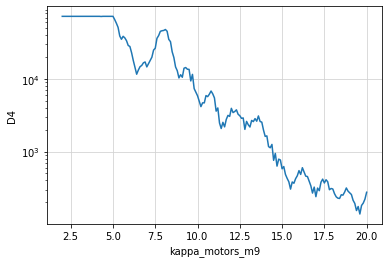

In [101]:
plot_latest(tth_motor,D4,log=True)

In [106]:
th2thx_plan_test(1,10,0.05,-1500,-5,komega)

npts: 181
x_start: -1500
x_stop: -2405
x_step: -5


In [102]:
RE(uank(2,1+komega))

()

In [103]:
srs4.sensitivity_unit.put(1); RE(bps.sleep(1));u=srs4.sensitivity_unit.get()
srs4.sensitivity_value.put(3); RE(bps.sleep(1)); v=srs4.sensitivity_value.get()
print(v,u)

10 nA/V


sensitivity: 10 nA/V
gain: 1e-08


Transient Scan ID: 116     Time: 2021-12-04 18:43:16
Persistent Unique Scan ID: 'c47e649e-afef-4120-9cf2-6f3b5460de27'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.5144798159599304             |
|                    mono_energy | 536.005994                     |
|              mono_mirror_pitch | 3.5813800048828126             |
|             mono_grating_pitch | 4.8544848388671875             |
|                    centroidM3R | 111.17391304347827             |
|                kappa_motors_m2 | -1205.121                      |
|                kappa_motors_m3 | -1500.03                       |
|                kappa_motors_m4 | -89.822                        |
|                kappa_motors_m9 | 2.0                            |
|                kappa_motors_m8 | 58.71814238179002              |
|                kappa_motors_m7 | 134.7560

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.5144049525260925             |
|                    mono_energy | 535.9965469                    |
|              mono_mirror_pitch | 3.5813568115234378             |
|             mono_grating_pitch | 4.854493994140625              |
|                    centroidM3R | 110.66666666666667             |
|                kappa_motors_m2 | -2405.059                      |
|                kappa_motors_m3 | -1500.05                       |
|                kappa_motors_m4 | -89.811                        |
|                kappa_motors_m9 | 20.0                           |
|                kappa_motors_m8 | 67.71914238179002              |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.04497336                    |
|                select_detector | d4                             |
+-----------------

MoveStatus(done=True, pos=motors_V4size, elapsed=1.1, success=True, settle_time=0.0)

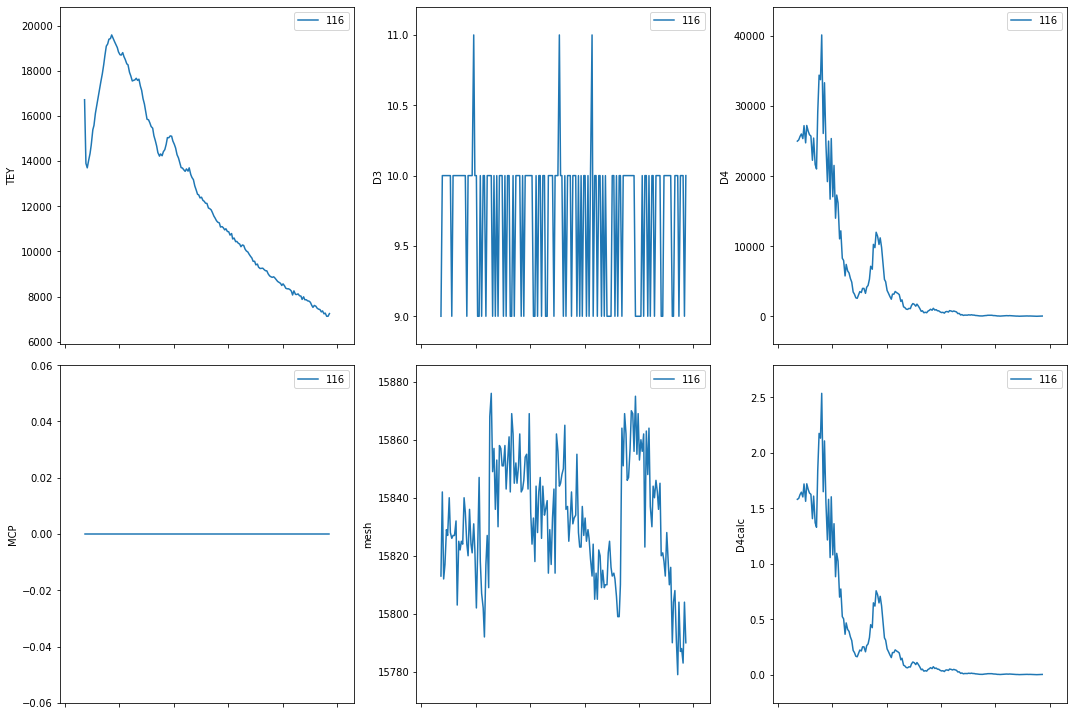

In [107]:
g=d4_gain();RE(th2thx_plan(1,10,0.05,-1500,-5,komega)); slits.V4size.move(0)

In [108]:
playsound()

Playing WAVE '/home/beams/29IDUSER/Documents/User_Macros/Macros_29id/Sound_Files/VictoryFF.wav' : Signed 16 bit Little Endian, Rate 48000 Hz, Stereo


/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


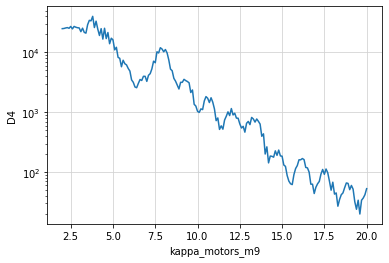

In [109]:
plot_latest(tth_motor,D4,log=True)

In [110]:
srs4.sensitivity_unit.put(0); RE(bps.sleep(1));u=srs4.sensitivity_unit.get()
srs4.sensitivity_value.put(5); RE(bps.sleep(1)); v=srs4.sensitivity_value.get()
print(v,u)

50 pA/V


In [111]:
RE(uank(14,7+komega))

()

sensitivity: 50 pA/V
gain: 5e-11


Transient Scan ID: 117     Time: 2021-12-04 18:49:31
Persistent Unique Scan ID: 'b5c1a780-c217-4f2e-a86c-f76937f9170c'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.5144798159599304             |
|                    mono_energy | 536.0025152                    |
|              mono_mirror_pitch | 3.5813897705078124             |
|             mono_grating_pitch | 4.8544830078125                |
|                    centroidM3R | 110.6086956521739              |
|                kappa_motors_m2 | -2405.127                      |
|                kappa_motors_m3 | -1500.049                      |
|                kappa_motors_m4 | -89.813                        |
|                kappa_motors_m9 | 14.0                           |
|                kappa_motors_m8 | 64.71814238179002              |
|                kappa_motors_m7 | 134.7560

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.5146296620368958             |
|                    mono_energy | 535.9921915                    |
|              mono_mirror_pitch | 3.5813330078125003             |
|             mono_grating_pitch | 4.854477514648438              |
|                    centroidM3R | 111.27272727272727             |
|                kappa_motors_m2 | -4605.044                      |
|                kappa_motors_m3 | -1500.06                       |
|                kappa_motors_m4 | -89.79                         |
|                kappa_motors_m9 | 56.0                           |
|                kappa_motors_m8 | 85.71914238179002              |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.04500324                    |
|                select_detector | d4                             |
+-----------------

MoveStatus(done=True, pos=motors_V4size, elapsed=1.1, success=True, settle_time=0.0)

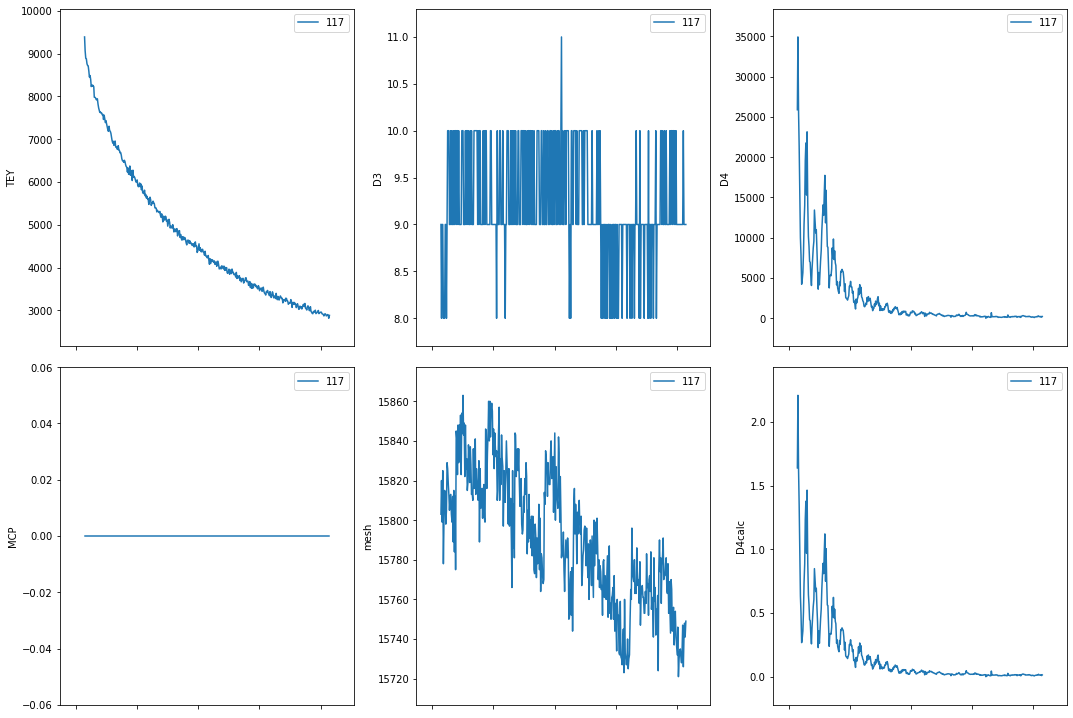

In [112]:
g=d4_gain()
slits.V4size.move(200)
RE(th2thx_plan(8,28,0.05,-2600,-5,komega))
slits.V4size.move(0)

In [129]:
playsound()

Playing WAVE '/home/beams/29IDUSER/Documents/User_Macros/Macros_29id/Sound_Files/VictoryFF.wav' : Signed 16 bit Little Endian, Rate 48000 Hz, Stereo


/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


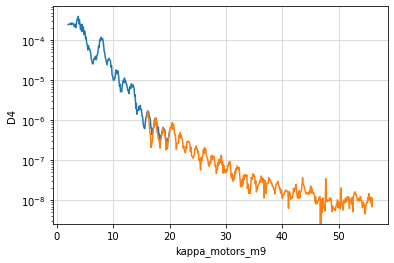

In [122]:
plot_run([[116,0,1e-8],[117,0,5e-11]],tth_motor,D4,log=True)

In [1]:
th2thx_plan_test(1,10,0.05,1400,-5,komega)

NameError: name 'th2thx_plan_test' is not defined

In [124]:
RE(uank(2,1+komega))

()

In [125]:
slits.V4size.move(300)

MoveStatus(done=True, pos=motors_V4size, elapsed=1.1, success=True, settle_time=0.0)

In [127]:
srs4.sensitivity_unit.put(1); RE(bps.sleep(1));u=srs4.sensitivity_unit.get()
srs4.sensitivity_value.put(3); RE(bps.sleep(1)); v=srs4.sensitivity_value.get()
print(v,u)

10 nA/V


sensitivity: 10 nA/V
gain: 1e-08


Transient Scan ID: 118     Time: 2021-12-04 19:06:09
Persistent Unique Scan ID: 'f72449bd-b78b-49e8-935b-ddea42f32777'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.5145546793937683             |
|                    mono_energy | 535.985313                     |
|              mono_mirror_pitch | 3.581378173828125              |
|             mono_grating_pitch | 4.854508642578125              |
|                    centroidM3R | 111.6                          |
|                kappa_motors_m2 | 0.027                          |
|                kappa_motors_m3 | -1500.0420000000001            |
|                kappa_motors_m4 | -89.811                        |
|                kappa_motors_m9 | 2.0                            |
|                kappa_motors_m8 | 58.71814238179002              |
|                kappa_motors_m7 | 134.7560

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.5147794485092163             |
|                    mono_energy | 535.9853635                    |
|              mono_mirror_pitch | 3.581395263671875              |
|             mono_grating_pitch | 4.854482397460938              |
|                    centroidM3R | 112.125                        |
|                kappa_motors_m2 | 1405.015                       |
|                kappa_motors_m3 | -1500.056                      |
|                kappa_motors_m4 | -89.805                        |
|                kappa_motors_m9 | 20.0                           |
|                kappa_motors_m8 | 67.71814238179002              |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.04496616                    |
|                select_detector | d4                             |
|         motors_H

MoveStatus(done=True, pos=motors_V4size, elapsed=1.1, success=True, settle_time=0.0)

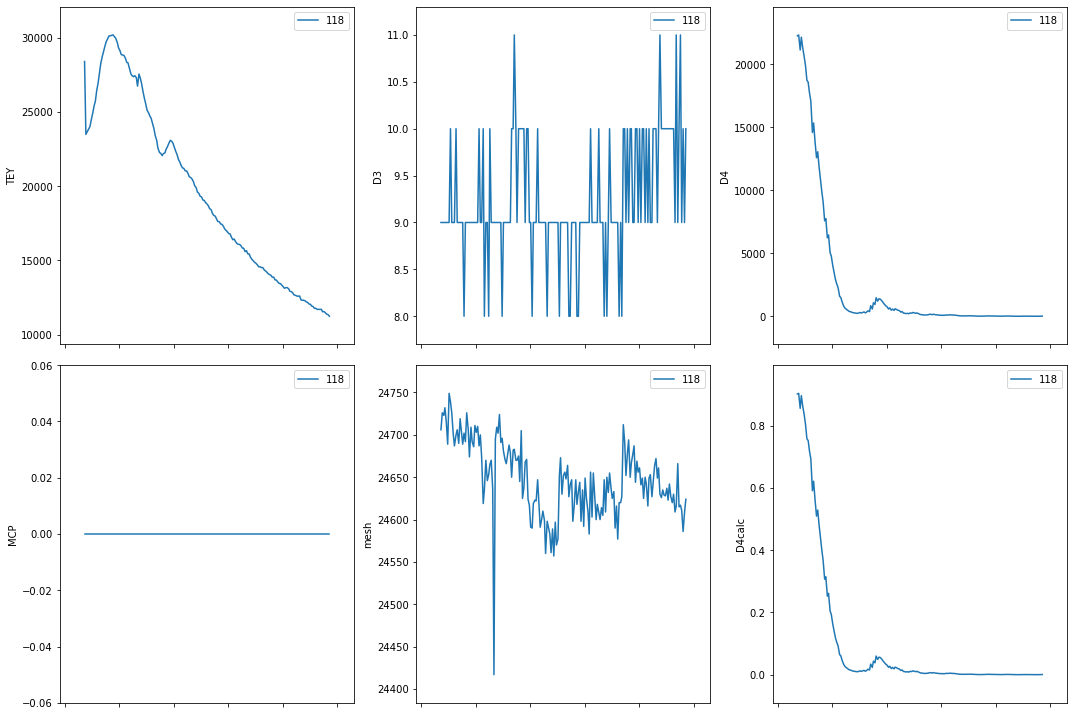

In [128]:
g=d4_gain();slits.V4size.move(300);RE(th2thx_plan(1,10,0.05,500,5,komega)); slits.V4size.move(0)

In [130]:
playsound()

Playing WAVE '/home/beams/29IDUSER/Documents/User_Macros/Macros_29id/Sound_Files/VictoryFF.wav' : Signed 16 bit Little Endian, Rate 48000 Hz, Stereo


/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


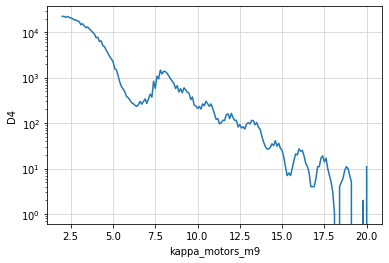

In [131]:
plot_latest(tth_motor,D4,log=True)

In [132]:
srs4.sensitivity_unit.put(0); RE(bps.sleep(1));u=srs4.sensitivity_unit.get()
srs4.sensitivity_value.put(5); RE(bps.sleep(1)); v=srs4.sensitivity_value.get()
print(v,u)

50 pA/V


In [133]:
RE(uank(14,7+komega))

()

sensitivity: 50 pA/V
gain: 5e-11


Transient Scan ID: 119     Time: 2021-12-04 19:16:13
Persistent Unique Scan ID: 'f5b2284d-1914-4b52-bec8-4208182958a7'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.5145546793937683             |
|                    mono_energy | 536.0042687                    |
|              mono_mirror_pitch | 3.581343994140625              |
|             mono_grating_pitch | 4.854505590820312              |
|                    centroidM3R | 114.22384964926987             |
|                kappa_motors_m2 | 1405.051                       |
|                kappa_motors_m3 | -1500.049                      |
|                kappa_motors_m4 | -89.806                        |
|                kappa_motors_m9 | 14.0                           |
|                kappa_motors_m8 | 64.71814238179002              |
|                kappa_motors_m7 | 134.7560

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.5144798159599304             |
|                    mono_energy | 536.0007674                    |
|              mono_mirror_pitch | 3.581400146484375              |
|             mono_grating_pitch | 4.854499487304688              |
|                    centroidM3R | 114.07373231391159             |
|                kappa_motors_m2 | 3705.023                       |
|                kappa_motors_m3 | -1500.068                      |
|                kappa_motors_m4 | -89.803                        |
|                kappa_motors_m9 | 56.0                           |
|                kappa_motors_m8 | 85.72014238179003              |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.04497336                    |
|                select_detector | d4                             |
|         motors_H

MoveStatus(done=True, pos=motors_V4size, elapsed=1.1, success=True, settle_time=0.0)

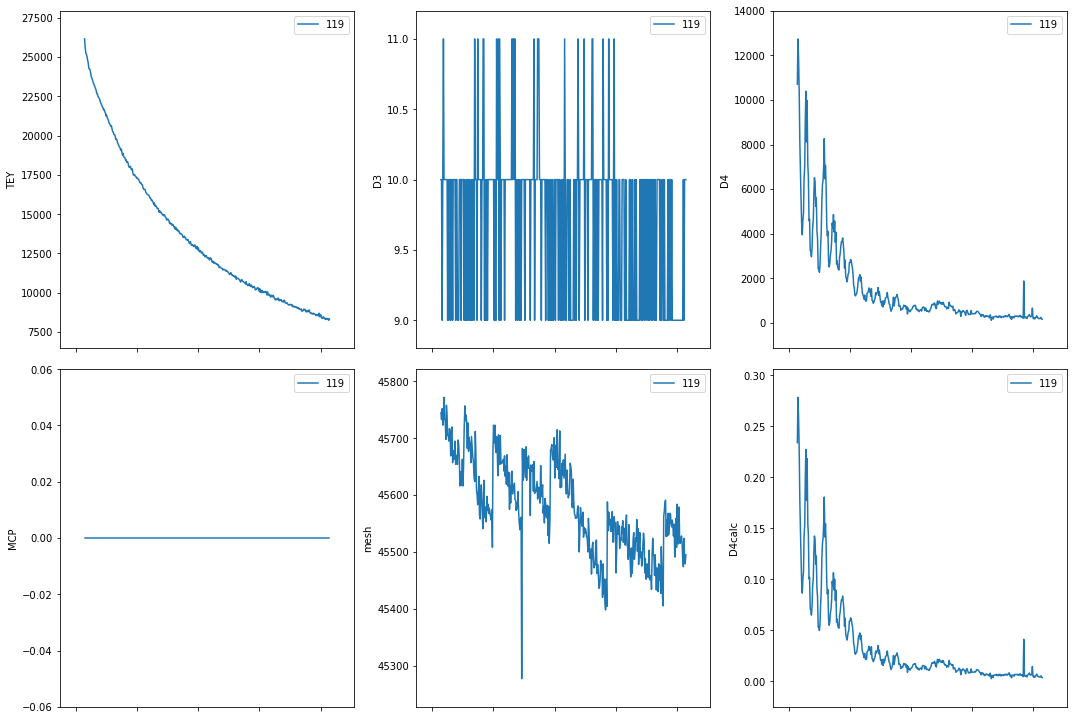

In [134]:
g=d4_gain()
slits.V4size.move(300)
RE(th2thx_plan(8,28,0.05,1700,5,komega))
slits.V4size.move(0)

In [135]:
playsound()

Playing WAVE '/home/beams/29IDUSER/Documents/User_Macros/Macros_29id/Sound_Files/VictoryFF.wav' : Signed 16 bit Little Endian, Rate 48000 Hz, Stereo


/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


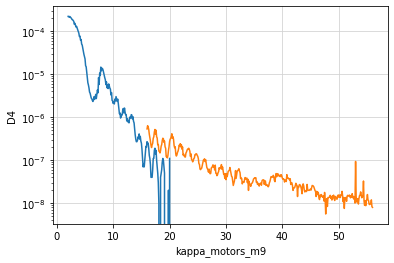

In [142]:
plot_run([[118,0,1e-8],[119,0,5e-11]],tth_motor,D4,log=True)

In [143]:
RE(uank(2,1+komega))

()

In [144]:
slits.V4size.move(300)

MoveStatus(done=True, pos=motors_V4size, elapsed=1.1, success=True, settle_time=0.0)

In [145]:
srs4.sensitivity_unit.put(1); RE(bps.sleep(1));u=srs4.sensitivity_unit.get()
srs4.sensitivity_value.put(3); RE(bps.sleep(1)); v=srs4.sensitivity_value.get()
print(v,u)

10 nA/V


sensitivity: 10 nA/V
gain: 1e-08


Transient Scan ID: 120     Time: 2021-12-04 19:27:49
Persistent Unique Scan ID: '28db195f-0423-4ba7-b94a-298326d18f1b'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.5147045254707336             |
|                    mono_energy | 536.0060727                    |
|              mono_mirror_pitch | 3.5813641357421875             |
|             mono_grating_pitch | 4.854468969726563              |
|                    centroidM3R | 114.2251740241431              |
|                kappa_motors_m2 | 3705.0570000000002             |
|                kappa_motors_m3 | -1500.046                      |
|                kappa_motors_m4 | -89.812                        |
|                kappa_motors_m9 | 2.0                            |
|                kappa_motors_m8 | 58.71814238179002              |
|                kappa_motors_m7 | 134.7560

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.5144049525260925             |
|                    mono_energy | 536.0056849                    |
|              mono_mirror_pitch | 3.5813232421875                |
|             mono_grating_pitch | 4.854477514648438              |
|                    centroidM3R | 114.35614356590533             |
|                kappa_motors_m2 | 4905.024                       |
|                kappa_motors_m3 | -1500.0620000000001            |
|                kappa_motors_m4 | -89.812                        |
|                kappa_motors_m9 | 20.0                           |
|                kappa_motors_m8 | 67.71814238179002              |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.04496616                    |
|                select_detector | d4                             |
|         motors_H

MoveStatus(done=True, pos=motors_V4size, elapsed=1.1, success=True, settle_time=0.0)

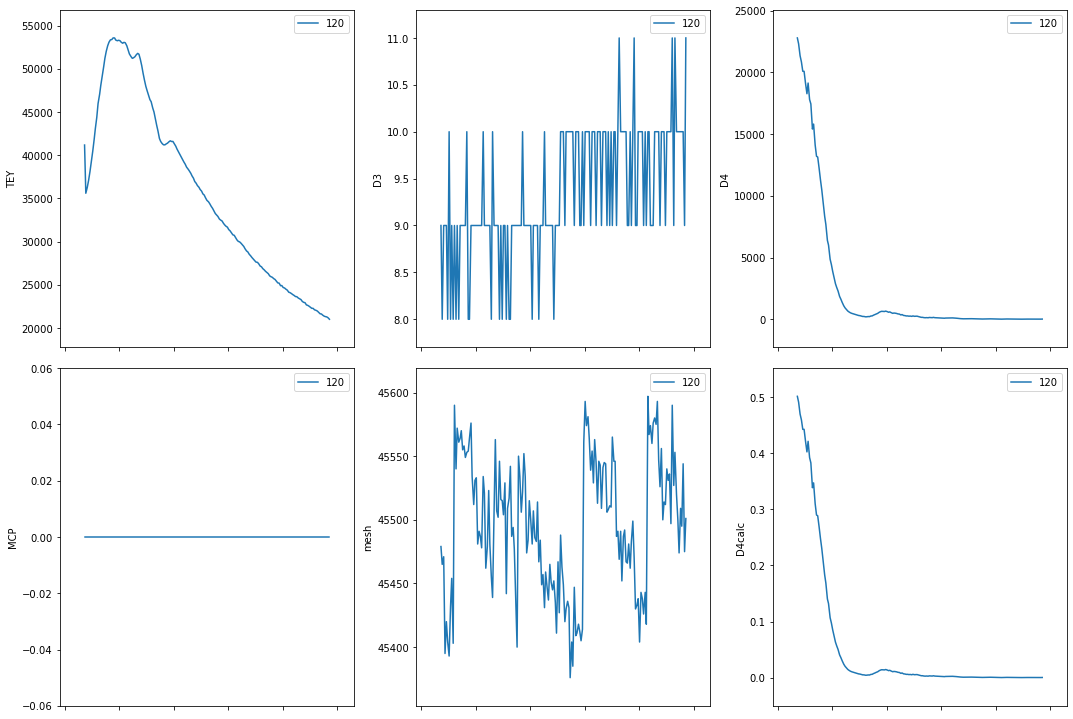

In [146]:
g=d4_gain();slits.V4size.move(300);RE(th2thx_plan(1,10,0.05,4000,5,komega)); slits.V4size.move(0)

In [147]:
playsound()

Playing WAVE '/home/beams/29IDUSER/Documents/User_Macros/Macros_29id/Sound_Files/VictoryFF.wav' : Signed 16 bit Little Endian, Rate 48000 Hz, Stereo


/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


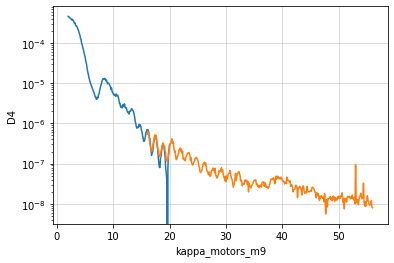

In [151]:
plot_run([[120,0,2e-8],[119,0,5e-11]],tth_motor,D4,log=True)

## E = 533.5 eV

In [3]: energy(533.5,c=0.5,m3r=False)
ID Ready

ID SET : 543.4 eV
ID RBV : 512.1 eV
Down Table
Mono set to 533.5 eV


Mono set to 533.5 eV

In [5]: SetSlit_BL(c2B=0.75)
Slit-1A = (1.901x1.767) @ (0.125,0.0)
Slit-2B = (2.0745x2.429) @ (-0.25,0.0)



In [152]:
RE(uank(2,1+komega))

()

In [ ]:
slits.V4size.move(300)

In [153]:
srs4.sensitivity_unit.put(1); RE(bps.sleep(1));u=srs4.sensitivity_unit.get()
srs4.sensitivity_value.put(2); RE(bps.sleep(1)); v=srs4.sensitivity_value.get()
print(v,u)

5 nA/V


sensitivity: 5 nA/V
gain: 5e-09


Transient Scan ID: 121     Time: 2021-12-04 19:43:22
Persistent Unique Scan ID: 'dd08bfba-7611-4abc-bd82-01b5b00f202e'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.5118691325187683             |
|                    mono_energy | 533.4876357                    |
|              mono_mirror_pitch | 3.5897564697265625             |
|             mono_grating_pitch | 4.8658636230468755             |
|                    centroidM3R | 110.73706538377432             |
|                kappa_motors_m2 | 4905.079                       |
|                kappa_motors_m3 | -1500.049                      |
|                kappa_motors_m4 | -89.816                        |
|                kappa_motors_m9 | 2.0                            |
|                kappa_motors_m8 | 58.71814238179002              |
|                kappa_motors_m7 | 134.75600

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.5118691325187683             |
|                    mono_energy | 533.4904528                    |
|              mono_mirror_pitch | 3.589720458984375              |
|             mono_grating_pitch | 4.865860571289063              |
|                    centroidM3R | 110.6821137147096              |
|                kappa_motors_m2 | 6105.025000000001              |
|                kappa_motors_m3 | -1500.058                      |
|                kappa_motors_m4 | -89.811                        |
|                kappa_motors_m9 | 20.0                           |
|                kappa_motors_m8 | 67.71714238179001              |
|                kappa_motors_m7 | 134.757                        |
|                kappa_motors_m1 | 57.0449586                     |
|                select_detector | d4                             |
|         motors_H

MoveStatus(done=True, pos=motors_V4size, elapsed=1.1, success=True, settle_time=0.0)

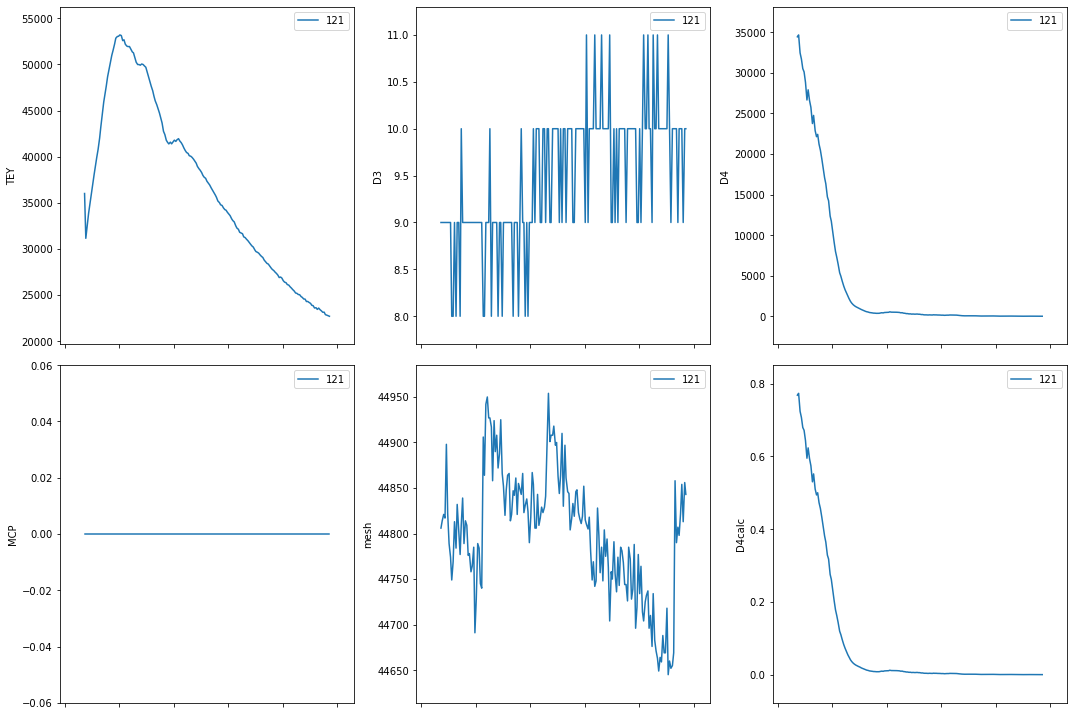

In [154]:
g=d4_gain();slits.V4size.move(300);RE(th2thx_plan(1,10,0.05,5200,5,komega)); slits.V4size.move(0)

In [155]:
playsound()

Playing WAVE '/home/beams/29IDUSER/Documents/User_Macros/Macros_29id/Sound_Files/VictoryFF.wav' : Signed 16 bit Little Endian, Rate 48000 Hz, Stereo


/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


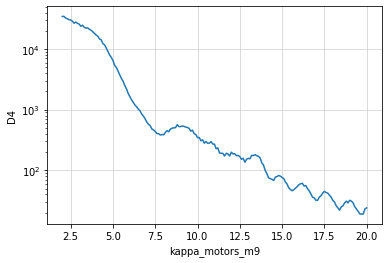

In [157]:
plot_latest(tth_motor,D4,log=True)

### Move from y = -1500 to +1500

In [159]:
srs4.sensitivity_unit.put(0); RE(bps.sleep(1));u=srs4.sensitivity_unit.get()
srs4.sensitivity_value.put(5); RE(bps.sleep(1)); v=srs4.sensitivity_value.get()
print(v,u)

50 pA/V


In [ ]:
RE(uank(14,7+komega))

sensitivity: 50 pA/V
gain: 5e-11


Transient Scan ID: 122     Time: 2021-12-04 19:50:48
Persistent Unique Scan ID: '7a7f1ab4-7c72-4759-b144-9e2ef6ae2753'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.5120921730995178             |
|                    mono_energy | 533.4953967                    |
|              mono_mirror_pitch | 3.58976318359375               |
|             mono_grating_pitch | 4.865863012695312              |
|                    centroidM3R | 110.51156209930583             |
|                kappa_motors_m2 | 6105.0960000000005             |
|                kappa_motors_m3 | 1500.212                       |
|                kappa_motors_m4 | -89.781                        |
|                kappa_motors_m9 | 20.0                           |
|                kappa_motors_m8 | 67.71814238179002              |
|                kappa_motors_m7 | 134.7560

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.5120921730995178             |
|                    mono_energy | 533.5075454                    |
|              mono_mirror_pitch | 3.5898193359375                |
|             mono_grating_pitch | 4.865878881835938              |
|                    centroidM3R | 110.68708666898712             |
|                kappa_motors_m2 | 3794.9410000000003             |
|                kappa_motors_m3 | 1500.2160000000001             |
|                kappa_motors_m4 | -89.771                        |
|                kappa_motors_m9 | 56.0                           |
|                kappa_motors_m8 | 85.71914238179002              |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.04489776                    |
|                select_detector | d4                             |
|         motors_H

MoveStatus(done=True, pos=motors_V4size, elapsed=1.5, success=True, settle_time=0.0)

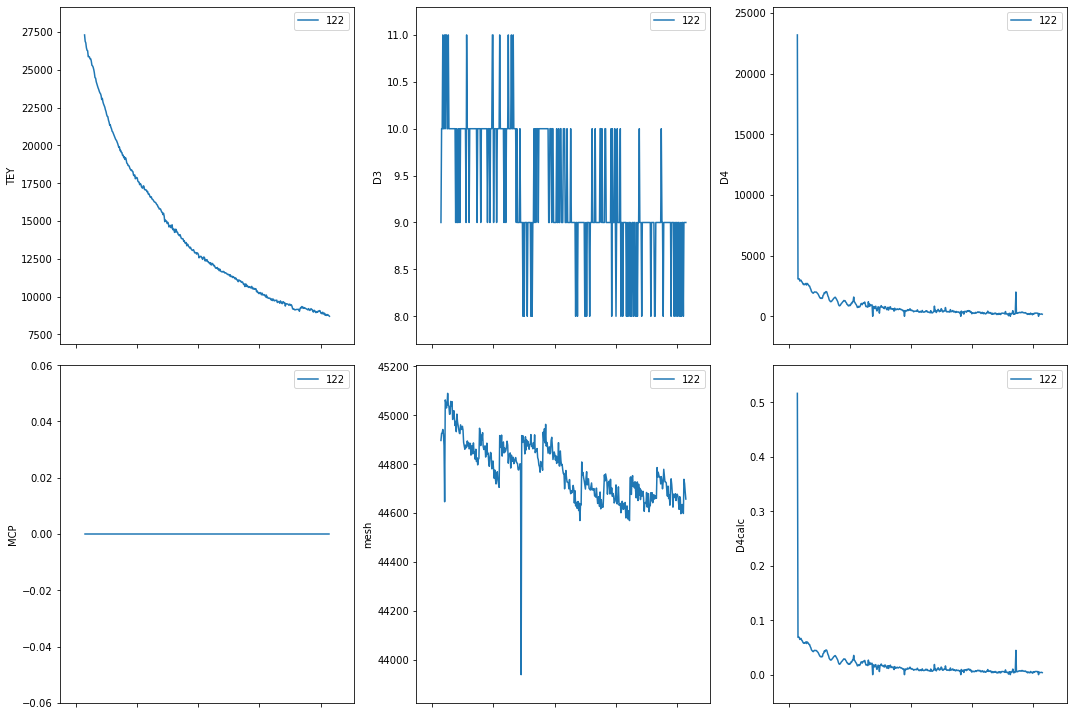

In [160]:
g=d4_gain()
slits.V4size.move(300)
RE(th2thx_plan(8,28,0.05,5800,-5,komega))
slits.V4size.move(0)

In [161]:
playsound()

Playing WAVE '/home/beams/29IDUSER/Documents/User_Macros/Macros_29id/Sound_Files/VictoryFF.wav' : Signed 16 bit Little Endian, Rate 48000 Hz, Stereo


/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


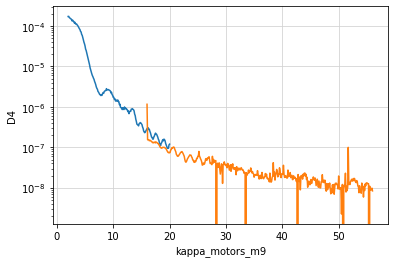

In [162]:
plot_run([[121,0,5e-9],[122,0,5e-11]],tth_motor,D4,log=True)

### Move from y = -1500 to +0

In [164]:

scaler.stage_sigs['preset_time']=0.2


In [159]:
srs4.sensitivity_unit.put(0); RE(bps.sleep(1));u=srs4.sensitivity_unit.get()
srs4.sensitivity_value.put(5); RE(bps.sleep(1)); v=srs4.sensitivity_value.get()
print(v,u)

50 pA/V


In [ ]:
RE(uank(14,7+komega))

In [166]:
mprint()

x,y,z,tth,th,chi,phi = [3795.0,0.0,-90.0,14.0,64.72,134.75600000000003,57.04]


[3795.0, 0.0, -90.0, 14.0, 64.72, 134.75600000000003, 57.04]

sensitivity: 50 pA/V
gain: 5e-11


Transient Scan ID: 123     Time: 2021-12-04 20:09:37
Persistent Unique Scan ID: 'a13bba46-576f-40a4-a46c-cc58748d72b8'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.5120921730995178             |
|                    mono_energy | 533.5060143                    |
|              mono_mirror_pitch | 3.5897930908203124             |
|             mono_grating_pitch | 4.865870947265625              |
|                    centroidM3R | 111.74685848502642             |
|                kappa_motors_m2 | 3794.838                       |
|                kappa_motors_m3 | 0.045                          |
|                kappa_motors_m4 | -89.791                        |
|                kappa_motors_m9 | 14.0                           |
|                kappa_motors_m8 | 64.71814238179002              |
|                kappa_motors_m7 | 134.7560

/home/beams/RODOLAKIS/.conda/envs/bluesky_2022_1/lib/python3.9/site-packages/bluesky/callbacks/fitting.py:166: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


End-of-run baseline readings:
+--------------------------------+--------------------------------+
|      undulator_energy_readback | 0.5117947459220886             |
|                    mono_energy | 533.5001125                    |
|              mono_mirror_pitch | 3.589779052734375              |
|             mono_grating_pitch | 4.86587216796875               |
|                    centroidM3R | 111.71561349328898             |
|                kappa_motors_m2 | 1494.951                       |
|                kappa_motors_m3 | -0.034                         |
|                kappa_motors_m4 | -89.773                        |
|                kappa_motors_m9 | 56.0                           |
|                kappa_motors_m8 | 85.71914238179002              |
|                kappa_motors_m7 | 134.75600000000003             |
|                kappa_motors_m1 | 57.04492044                    |
|                select_detector | d4                             |
|         motors_H

MoveStatus(done=True, pos=motors_V4size, elapsed=1.5, success=True, settle_time=0.0)

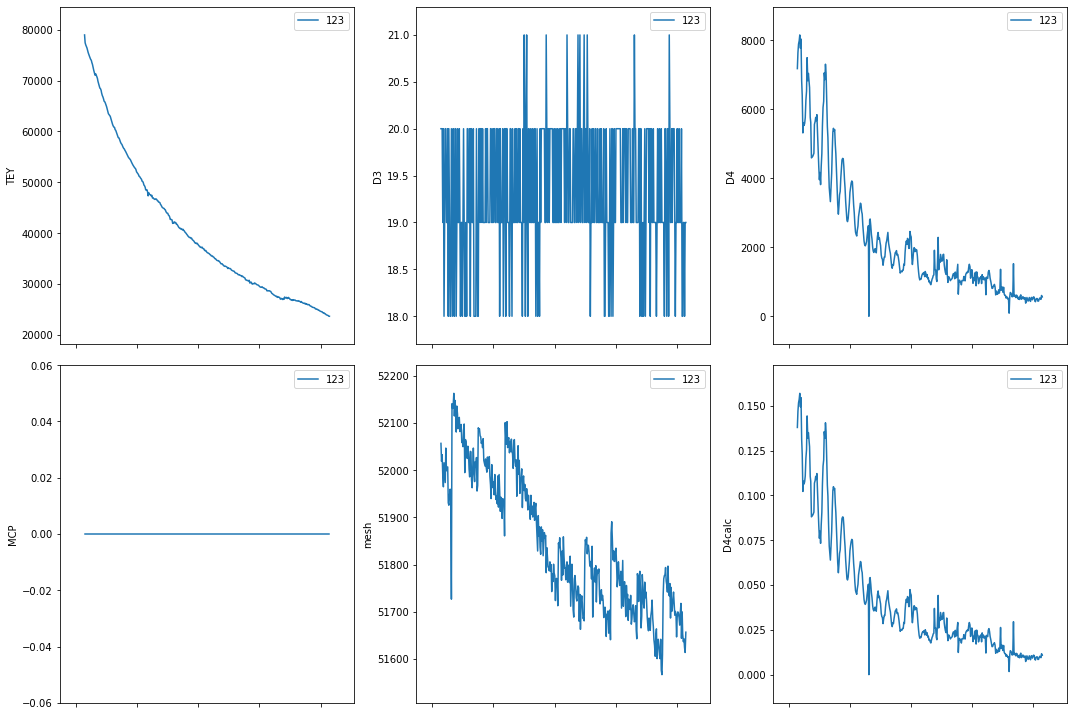

In [167]:
g=d4_gain()
slits.V4size.move(300)
RE(th2thx_plan(8,28,0.05,3500,-5,komega))
slits.V4size.move(0)

In [168]:
playsound()

Playing WAVE '/home/beams/29IDUSER/Documents/User_Macros/Macros_29id/Sound_Files/VictoryFF.wav' : Signed 16 bit Little Endian, Rate 48000 Hz, Stereo


/home/beams/29IDUSER/Documents/User_Folders/lastfigure.png


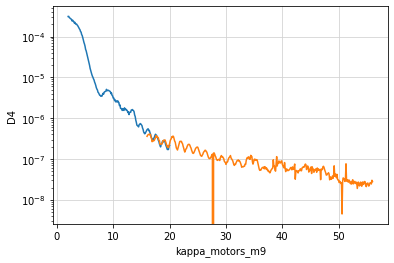

In [175]:
plot_run([[121,0,9e-9],[123,0,5e-11]],tth_motor,D4,log=True)